# __Neural Academy Final Project__

## Option 5  - Credit Risk dataset 
(source: https://www.kaggle.com/datasets/laotse/credit-risk-dataset)

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_recall_curve
from sklearn import set_config

import warnings
warnings.filterwarnings('ignore')

set_config(display='diagram')

In [2]:
#Load dataset
loan = pd.read_csv('credit_risk_dataset.csv')

### Exploratory Data Analysis

The dataset is composed of 12 columns, description of the columns is reported in the table here below:

| Feature Name: | Description: | 
| --- | --- |
| person_age | Age | 
| person_income | Annual Income |
| person_home_ownership | Home ownership |
| person_emp_length | Employment length (in years) |
| loan_intent |	Loan intent |
| loan_grade | Loan grade |
| loan_amnt | Loan amount |
| loan_int_rate | Interest rate |
| loan_status |	Loan status (0 is non default 1 is default) |
| loan_percent_income |	Percent income |
| cb_person_default_on_file | Historical default |
| cb_preson_cred_hist_length | Credit history length |

In [3]:
#Visualize Dataframe
loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
#Visualize dataframe information
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


The problem consists in predicting a label for each loan/person. The target column, named 'loan_status' provides a binary classification for the loan status (0 if not default, 1 if default). The 11 features can be split in 7 numerical features and 4 categorical features which will need to be processed separately. Here below we can explore the statistics of the numerical features plus the target.

In [5]:
#Visualize dataframe statistics
loan.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


One of the first things that we notice is that the dataset is highly unbalanced. Target population shares are relatively 78% for class 0 (non default) and 22% for class 1 (default).

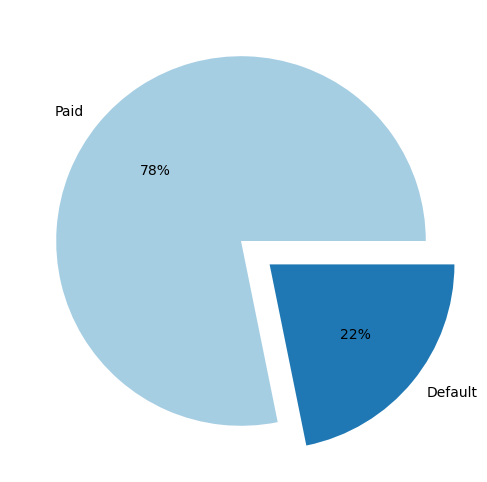

In [6]:
#Target population balance

plt.figure(figsize = (15,6))

#define Seaborn color palette
colors = sns.color_palette('Paired')[0:5] 

#define labels
labels = ['Paid','Default']
explode = [0, 0.2]

#create pie chart
plt.pie(loan['loan_status'].value_counts(), explode=explode, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

Here below we plot all the features separately in order to show any dependence on the target.

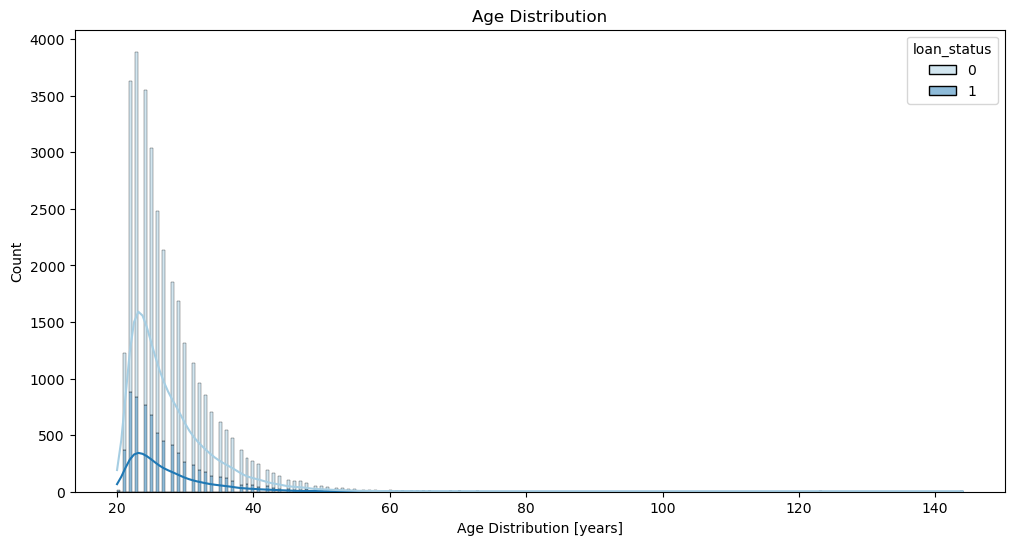

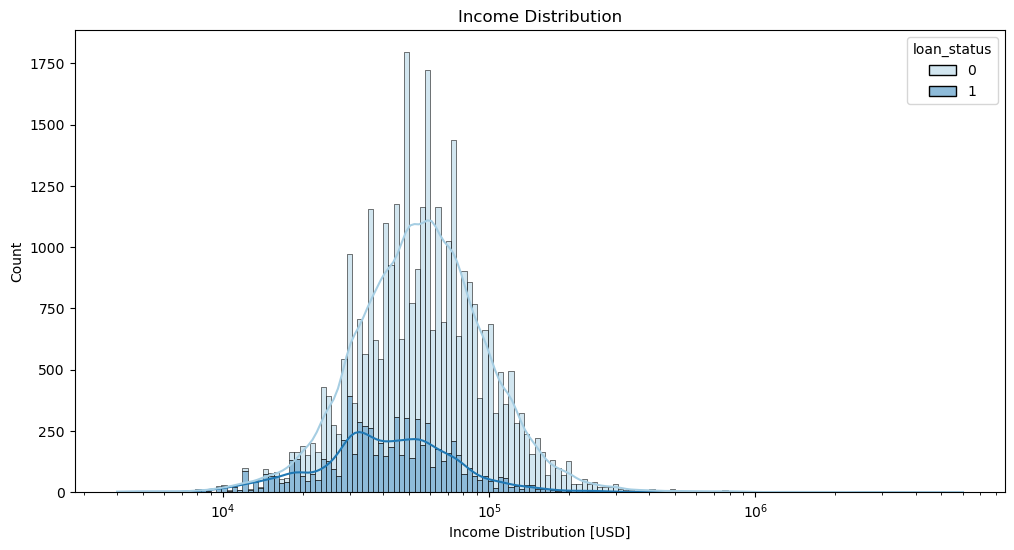

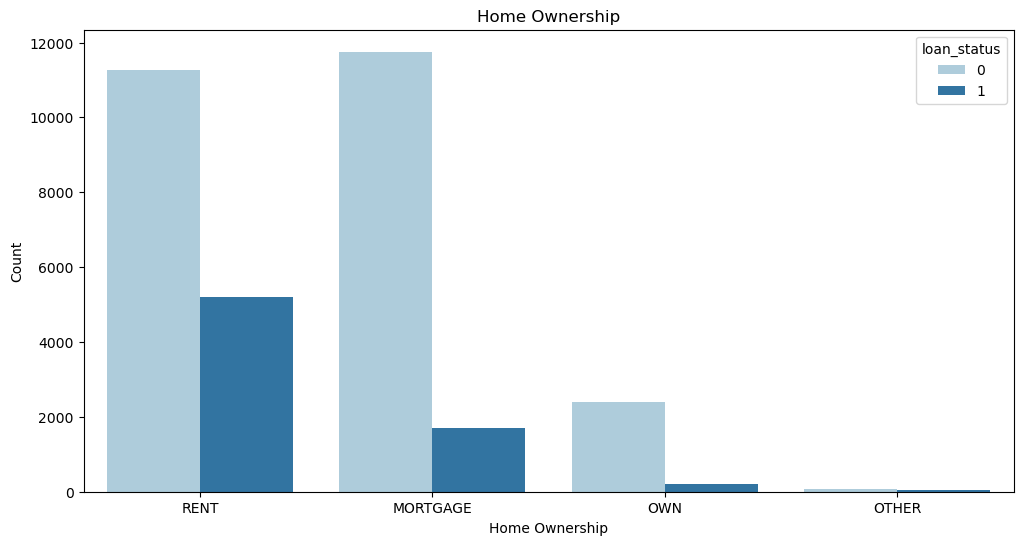

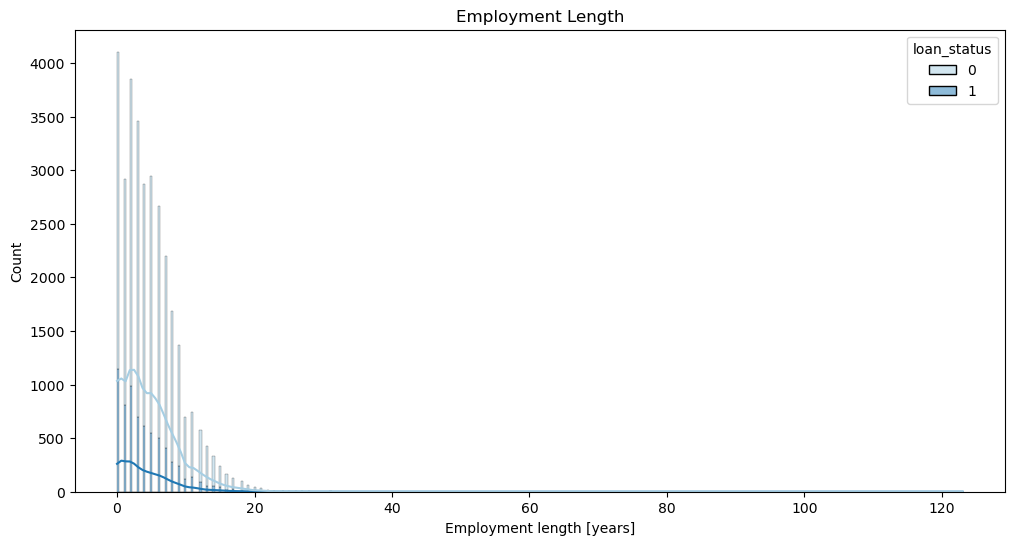

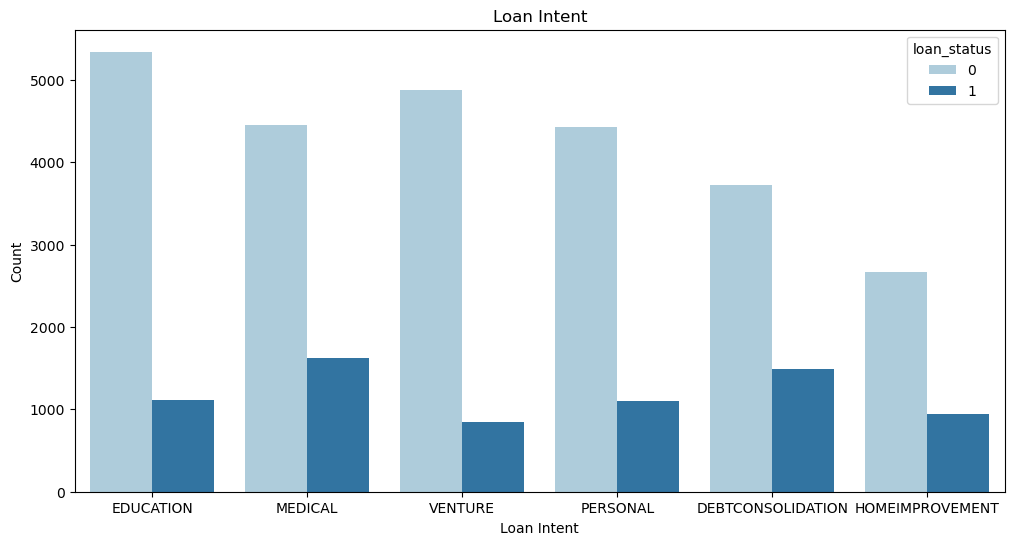

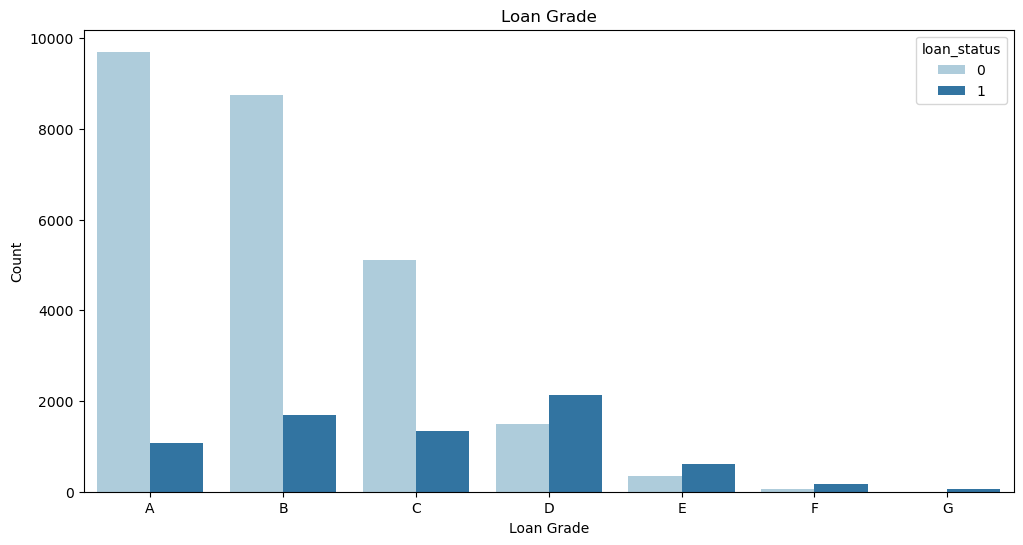

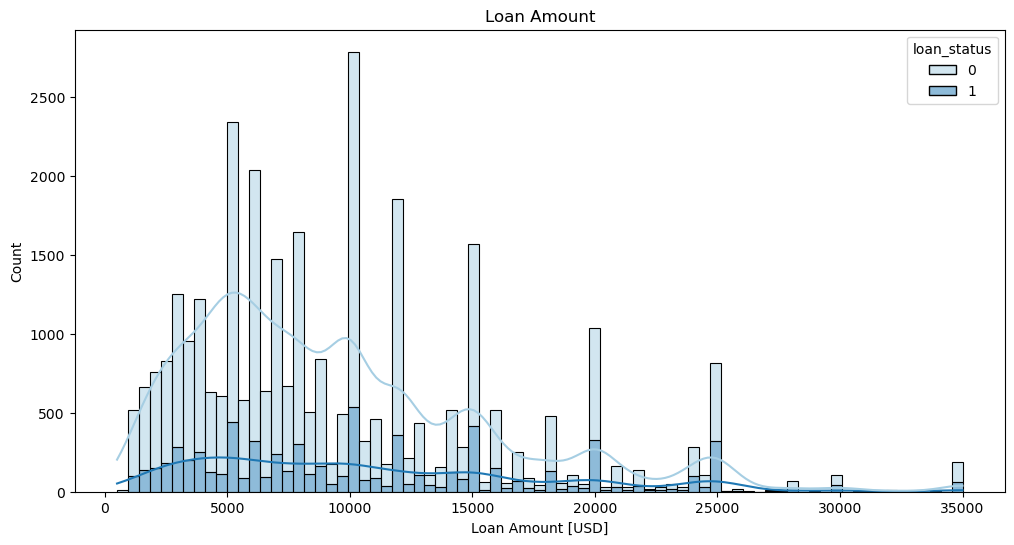

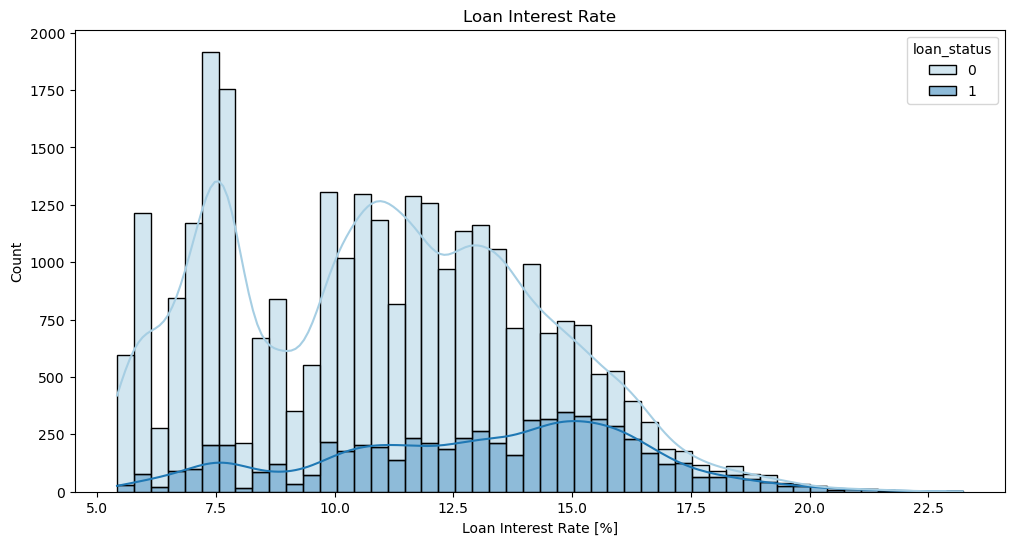

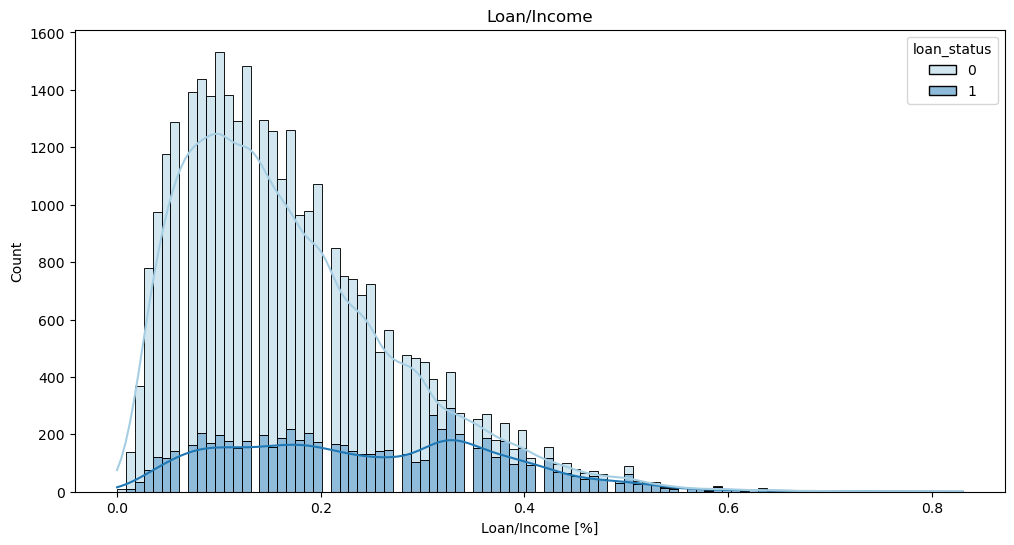

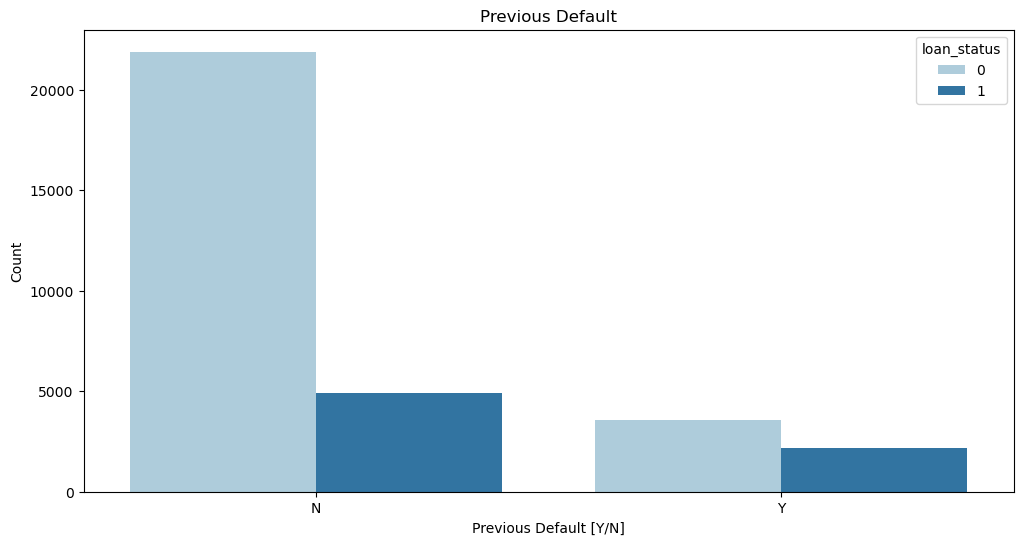

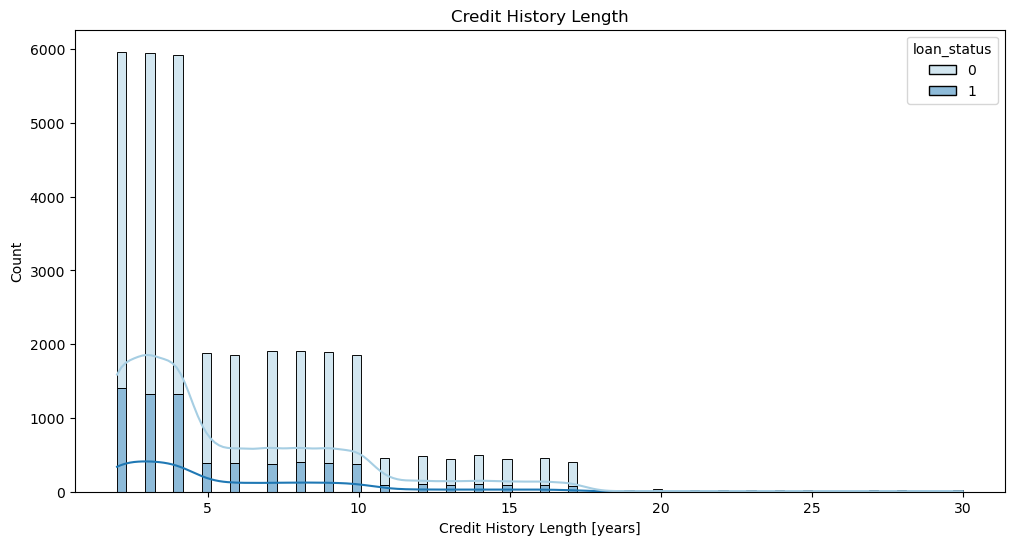

In [7]:
#Plot Features

sns.set_palette('Paired')

#Plot Age Distribution
plt.figure(figsize = (12,6))
sns.histplot(data=loan, x='person_age', hue='loan_status', multiple='stack', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age Distribution [years]')
plt.ylabel('Count')
plt.show()

#Plot Income Distribution
plt.figure(figsize = (12,6))
sns.histplot(data=loan, x='person_income', hue='loan_status', multiple='stack', log_scale=True, kde=True)
plt.title('Income Distribution')
plt.xlabel('Income Distribution [USD]')
plt.ylabel('Count')
plt.show()

#Plot Home Ownership
plt.figure(figsize = (12,6))
# Create a new DataFrame with the value counts for 'loan_intent' and 'loan_status'
home_counts = loan.groupby(['person_home_ownership', 'loan_status']).size().reset_index(name='count')
home_order = loan['person_home_ownership'].value_counts().sort_values(ascending=False).index
# Create a barplot of 'loan_intent' with 'loan_status' as a hue
sns.barplot(x='person_home_ownership', y='count', hue='loan_status', data=home_counts, order=home_order)
plt.title('Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()

#Plot Employment Length
plt.figure(figsize = (12,6))
sns.histplot(data=loan, x='person_emp_length', hue='loan_status', multiple='stack', kde=True)
plt.title('Employment Length')
plt.xlabel('Employment length [years]')
plt.ylabel('Count')
plt.show()

#Plot Loan Intent
plt.figure(figsize = (12,6))
# Create a new DataFrame with the value counts for 'loan_intent' and 'loan_status'
intent_counts = loan.groupby(['loan_intent', 'loan_status']).size().reset_index(name='count')
intent_order = loan['loan_intent'].value_counts().sort_values(ascending=False).index
# Create a barplot of 'loan_intent' with 'loan_status' as a hue
sns.barplot(x='loan_intent', y='count', hue='loan_status', data=intent_counts, order=intent_order)
plt.title('Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Count')
plt.show()

#Plot Loan Grade
plt.figure(figsize = (12,6))
# Create a new DataFrame with the value counts for 'loan_intent' and 'loan_status'
grade_counts = loan.groupby(['loan_grade', 'loan_status']).size().reset_index(name='count')
grade_order = loan['loan_grade'].value_counts().sort_values(ascending=False).index
# Create a barplot of 'loan_intent' with 'loan_status' as a hue
sns.barplot(x='loan_grade', y='count', hue='loan_status', data=grade_counts, order=grade_order)
plt.title('Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.show()

#Plot Loan Amount
plt.figure(figsize = (12,6))
sns.histplot(data=loan, x='loan_amnt', hue='loan_status', multiple='stack', kde=True)
plt.title('Loan Amount')
plt.xlabel('Loan Amount [USD]')
plt.ylabel('Count')
plt.show()

#Plot Interest Rate
plt.figure(figsize = (12,6))
sns.histplot(data=loan, x='loan_int_rate', hue='loan_status', multiple='stack', kde=True)
plt.title('Loan Interest Rate')
plt.xlabel('Loan Interest Rate [%]')
plt.ylabel('Count')
plt.show()

#Plot Loan/Income
plt.figure(figsize = (12,6))
sns.histplot(data=loan, x='loan_percent_income', hue='loan_status', multiple='stack', kde=True)
plt.title('Loan/Income')
plt.xlabel('Loan/Income [%]')
plt.ylabel('Count')
plt.show()

#Plot Previous Default
plt.figure(figsize = (12,6))
# Create a new DataFrame with the value counts for 'loan_intent' and 'loan_status'
default_counts = loan.groupby(['cb_person_default_on_file', 'loan_status']).size().reset_index(name='count')
default_order = loan['cb_person_default_on_file'].value_counts().sort_values(ascending=False).index
# Create a barplot of 'loan_intent' with 'loan_status' as a hue
sns.barplot(x='cb_person_default_on_file', y='count', hue='loan_status', data=default_counts, order=default_order)
plt.title('Previous Default')
plt.xlabel('Previous Default [Y/N]')
plt.ylabel('Count')
plt.show()

#Plot Credit History Length
plt.figure(figsize = (12,6))
sns.histplot(data=loan, x='cb_person_cred_hist_length', hue='loan_status', multiple='stack', kde=True)
plt.title('Credit History Length')
plt.xlabel('Credit History Length [years]')
plt.ylabel('Count')
plt.show()

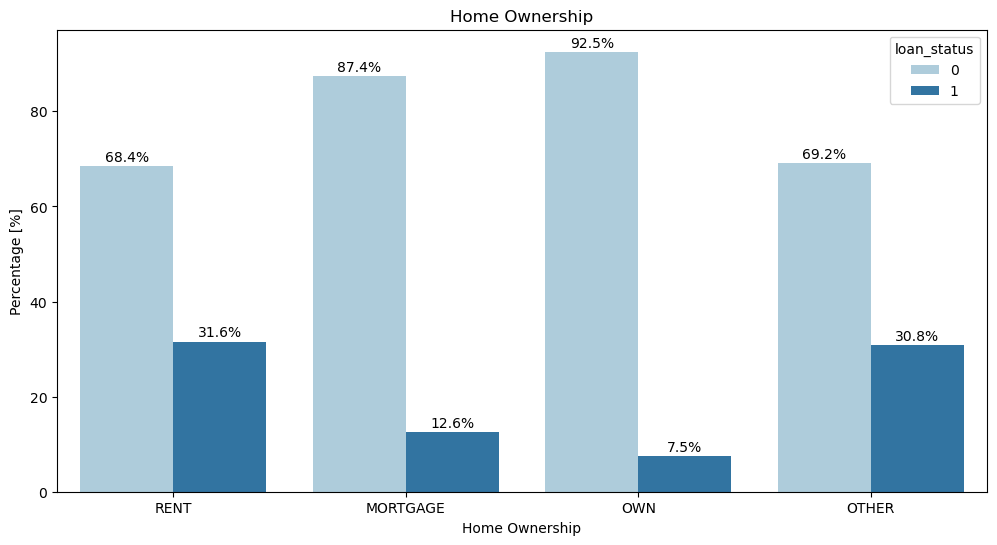

In [8]:
#Plot Loan Grade Percentage
plt.figure(figsize = (12,6))

home= loan.groupby(['person_home_ownership','loan_status']).size()

# Calculate the total count for each category in person_home_ownership
total_count_home = loan.groupby(['person_home_ownership']).size()

# Calculate the percentage for each group
home_percentage = (home / total_count_home*100).reset_index()
home_percentage.rename(columns={0: 'percentage'}, inplace=True)

# Create a barplot of 'loan_intent' with 'loan_status' as a hue
sns.barplot(x='person_home_ownership', y='percentage', hue='loan_status', data=home_percentage, order=home_order)
plt.title('Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Percentage [%]')

# Add percentage labels to the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center')

plt.show()

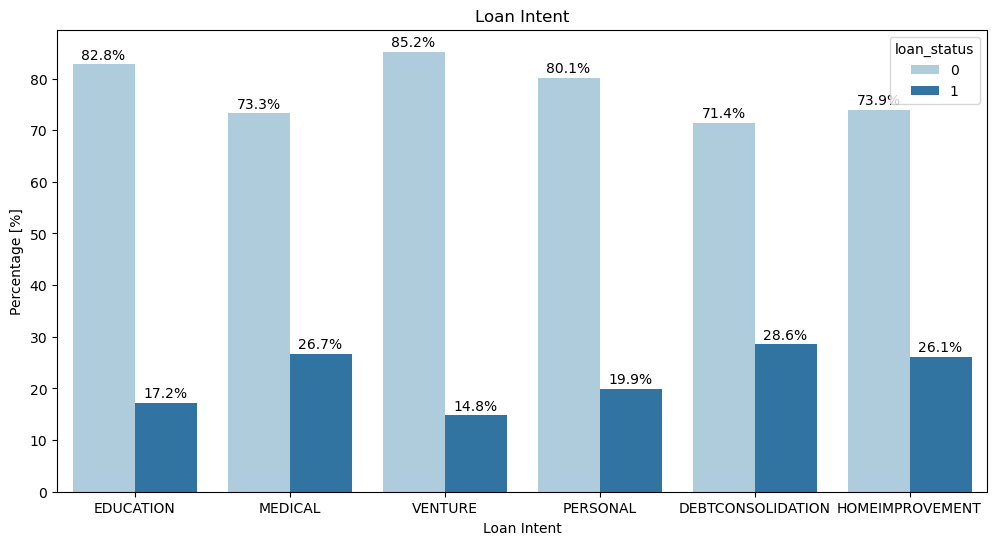

In [9]:
#Plot Loan Intent Percentage
plt.figure(figsize = (12,6))

intent= loan.groupby(['loan_intent','loan_status']).size()

# Calculate the total count for each category in loan_intent
total_count_intent = loan.groupby(['loan_intent']).size()

# Calculate the percentage for each group
intent_percentage = (intent/ total_count_intent*100).reset_index()
intent_percentage.rename(columns={0: 'percentage'}, inplace=True)

# Create a barplot of 'loan_intent' with 'loan_status' as a hue
sns.barplot(x='loan_intent', y='percentage', hue='loan_status', data=intent_percentage, order=intent_order)
plt.title('Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Percentage [%]')

# Add percentage labels to the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center')

plt.show()

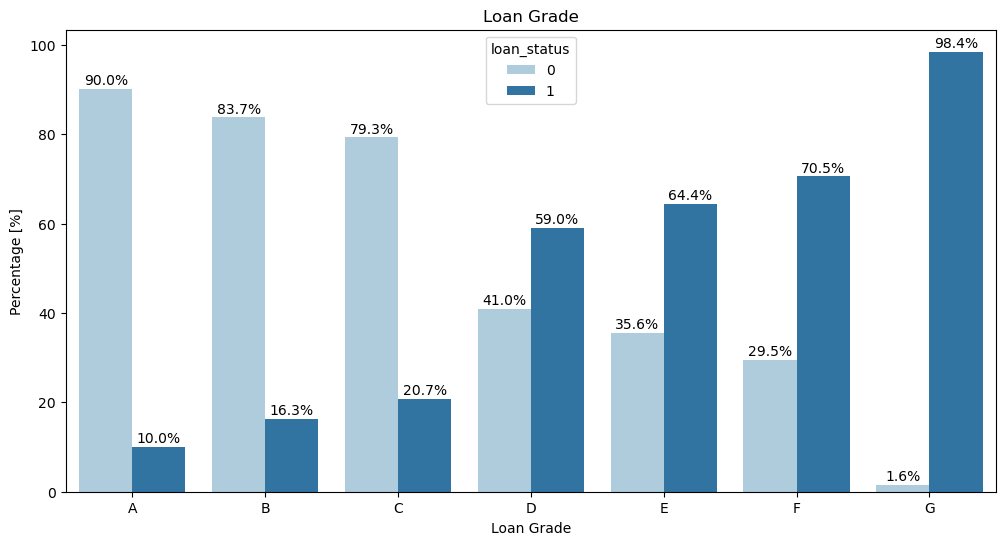

In [10]:
#Plot Loan Grade Percentage
plt.figure(figsize = (12,6))

grade= loan.groupby(['loan_grade','loan_status']).size()

# Calculate the total count for each category in loan_grade
total_count_grade = loan.groupby(['loan_grade']).size()

# Calculate the percentage for each group
grade_percentage = (grade/ total_count_grade*100).reset_index()
grade_percentage.rename(columns={0: 'percentage'}, inplace=True)

# Create a barplot of 'loan_grade' with 'loan_status' as a hue
sns.barplot(x='loan_grade', y='percentage', hue='loan_status', data=grade_percentage, order=grade_order)
plt.title('Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Percentage [%]')

# Add percentage labels to the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center')

plt.show()

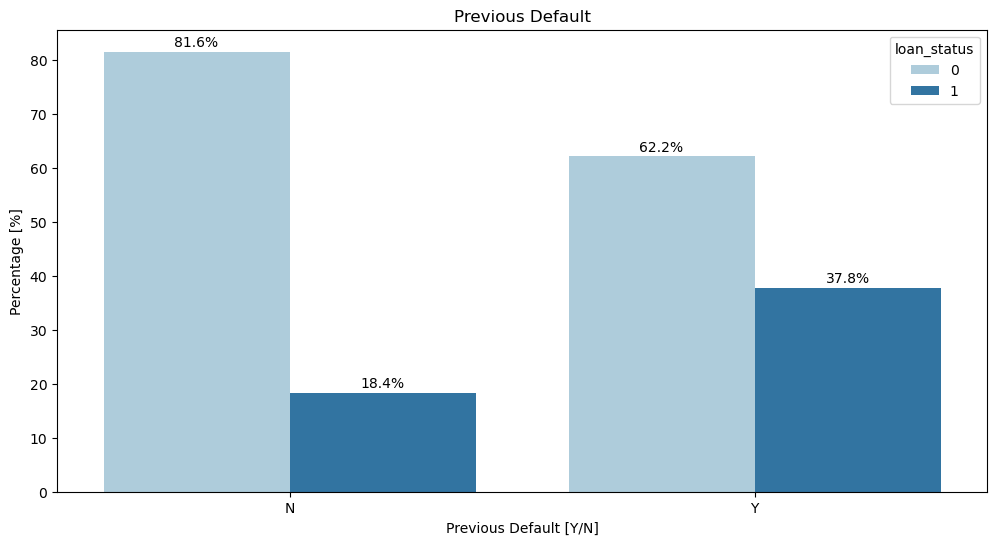

In [11]:
#Plot Previous Default Percentage
plt.figure(figsize = (12,6))

default = loan.groupby(['cb_person_default_on_file','loan_status']).size()

# Calculate the total count for each category in cb_person_default_on_file
total_count_default = loan.groupby(['cb_person_default_on_file']).size()

# Calculate the percentage for each group
default_percentage = (default/ total_count_default*100).reset_index()
default_percentage.rename(columns={0: 'percentage'}, inplace=True)

# Create a barplot of 'cb_person_default_on_file' with 'loan_status' as a hue
sns.barplot(x='cb_person_default_on_file', y='percentage', hue='loan_status', data=default_percentage, order=default_order)
plt.title('Previous Default')
plt.xlabel('Previous Default [Y/N]')
plt.ylabel('Percentage [%]')

# Add percentage labels to the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center')

plt.show()

From the plots above we can clearly depict a qualitative profile of the defaulted customer:

- Defaulted customers are younger than non defaulted customers and have a lower income. 

- Moreover most of the defaulted customers rent a house, and only a few of them are home owners. 

- Most of the defaulted customers apply for a loan for debt consolidation, medical reasons or home improvements.

- Loan grade for defaulted customers is generally much lower than all other customers.

- Interest rates and loan/income ratio are generally higher for defaulted customers. 

- Defaulted customers show also a higher number of previous defaults than non defaulted customers.

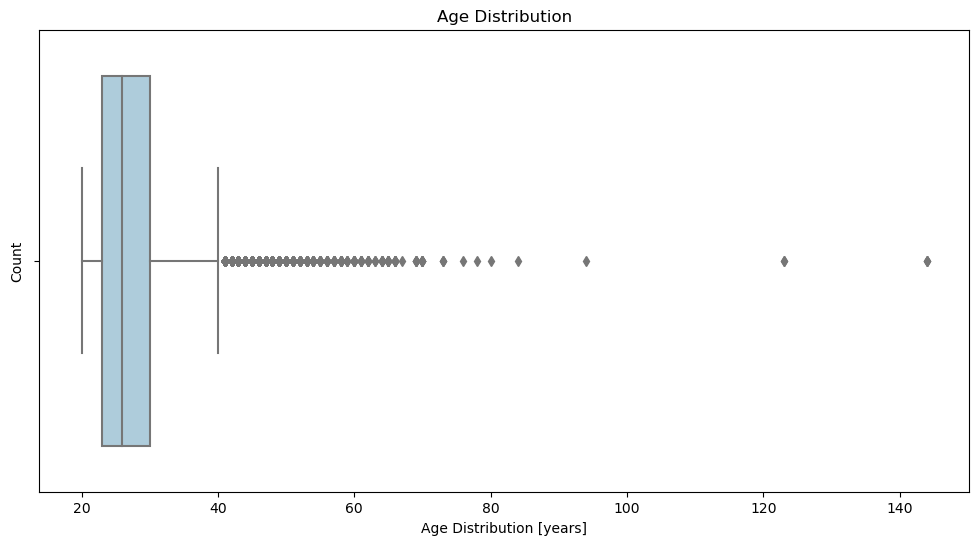

In [12]:
#Plot Age Distribution boxplot
plt.figure(figsize = (12,6))
sns.boxplot(data=loan, x='person_age', hue='loan_status')
plt.title('Age Distribution')
plt.xlabel('Age Distribution [years]')
plt.ylabel('Count')
plt.show()

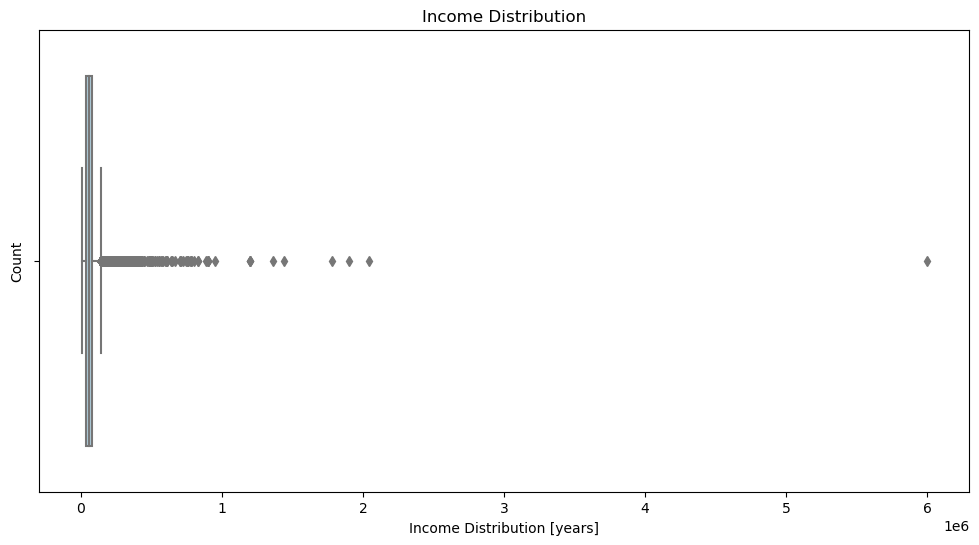

In [13]:
#Plot Income Distribution boxplot
plt.figure(figsize = (12,6))
sns.boxplot(data=loan, x='person_income', hue='loan_status')
plt.title('Income Distribution')
plt.xlabel('Income Distribution [years]')
plt.ylabel('Count')
plt.show()

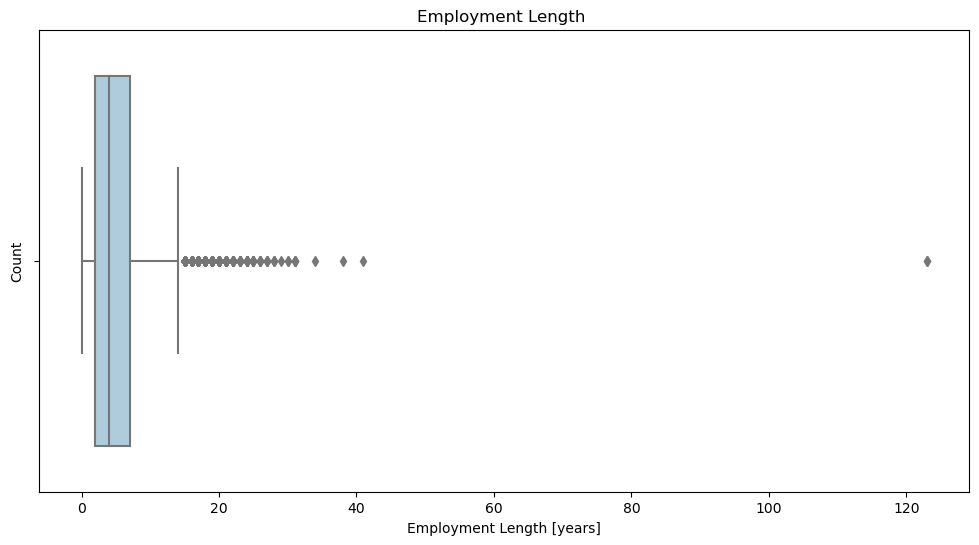

In [14]:
#Plot Employment length boxplot
plt.figure(figsize = (12,6))
sns.boxplot(data=loan, x='person_emp_length', hue='loan_status')
plt.title('Employment Length ')
plt.xlabel('Employment Length [years]')
plt.ylabel('Count')
plt.show()

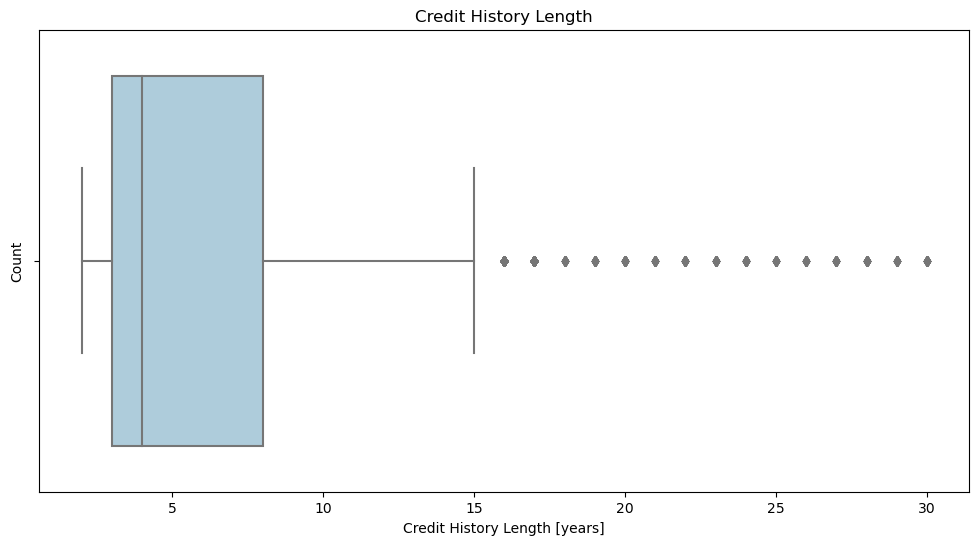

In [15]:
#Plot Credit history length boxplot
plt.figure(figsize = (12,6))
sns.boxplot(data=loan, x='cb_person_cred_hist_length', hue='loan_status')
plt.title('Credit History Length')
plt.xlabel('Credit History Length [years]')
plt.ylabel('Count')
plt.show()

The 4 boxplot above show a significant number of outliers in person_age, person_income, person_emp_length and cb_person_cred_hist_length. In particular there are a few outliers in person_age and person_emp_length above 122 years. We are going to treat them in the next chapter.

### Data Cleaning

First of all we check the number of Nans. person_emp_length has 887 Nans and loan_int_rate has 3094 Nans. We are going to substitute them later on using the average of all samples.

In [16]:
loan.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

We have also found 165 duplicate rows in the dataset, that need to be removed:

In [17]:
#Count Duplicate rows
loan.duplicated().sum()

165

In [18]:
#Remove duplicates
loan = loan.drop_duplicates()
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           31529 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               29321 non-null  float64
 8   loan_status                 32416 non-null  int64  
 9   loan_percent_income         32416 non-null  float64
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [19]:
#Count Duplicate rows
loan.duplicated().sum()

0

The correlation matrix shown here below helps us to identify and quantify feature correlation between couples of numerical features. 

In [20]:
#Heat map Correlation matrix
fig = px.imshow(loan.corr(),x=list(loan.corr().columns),y=list(loan.corr().columns),width=800, height=800)
fig.show()

Correlation between cb_person_cred_hist_length and person_age is 0.86 which is a relatively high value. The plot below shows clearly the linear correlation between the two features. For this reason we choose to drop one of the two features, in particular we drop cb_person_cred_hist_length from the dataset.

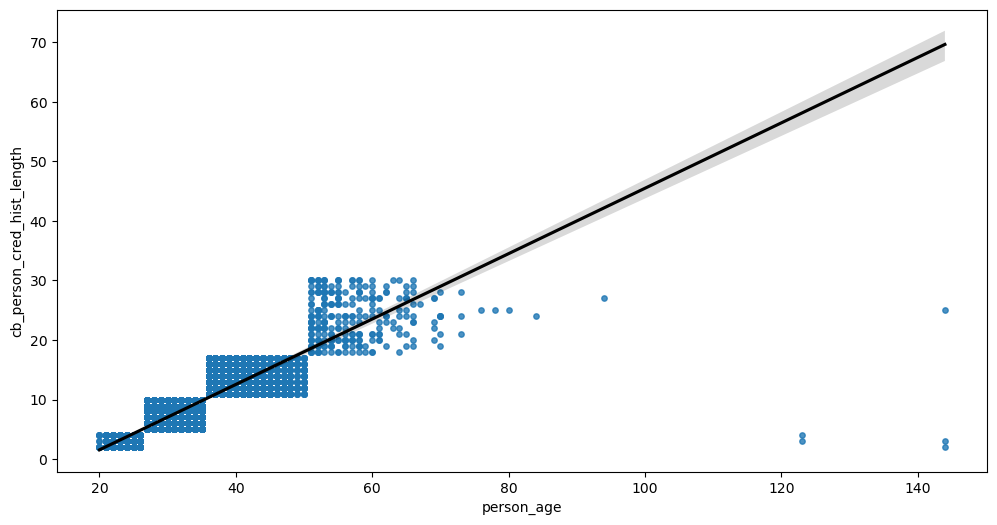

In [21]:
sns.set_palette('Paired')
plt.figure(figsize = (12,6))
sns.regplot(data=loan, x='person_age', y='cb_person_cred_hist_length', line_kws={'color': 'black'}, scatter_kws={'s': 15})
plt.show()

In [22]:
#Drop Credit History Length feature
loan = loan.drop(['cb_person_cred_hist_length'], axis=1) #Drop Credit History Length feature

Another interesting detail coming out from the EDA is that there are a few outliers in the person_age feature. In particular we identified 5 persons above 122 years, which is the maximum certified age of a human being so far (source: https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people). We decide to drop these samples from the dataset.

In [23]:
loan.loc[loan['person_age'] > 122] #Person age above 122 years

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N


In [24]:
loan = loan.drop(loan[loan['person_age'] > 122].index) #Drop Person age above 122 years

Here below we plot new the age distribution after dropping the outliers.

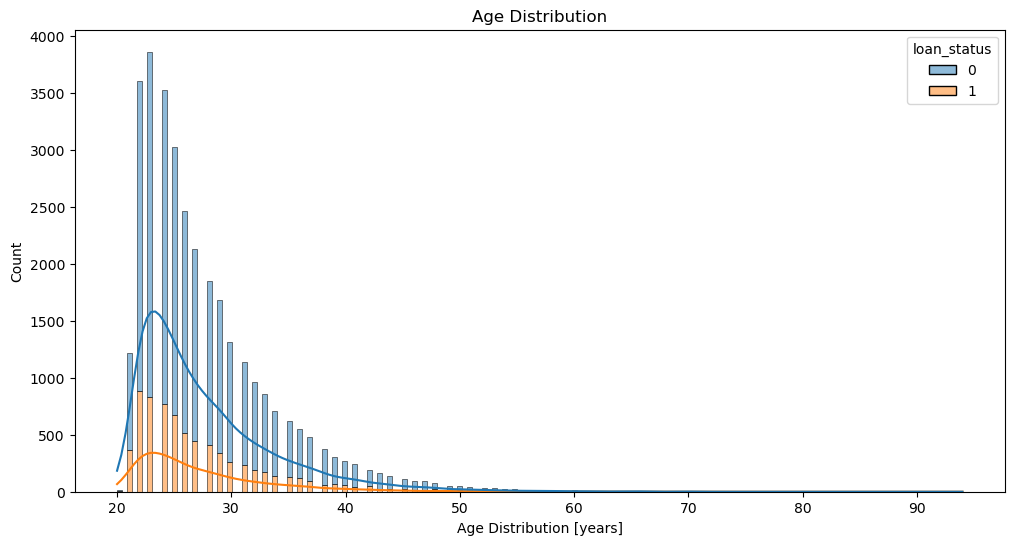

In [25]:
sns.set_palette('Paired')
plt.figure(figsize = (12,6))
sns.histplot(data=loan, x='person_age', hue='loan_status', multiple='stack', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age Distribution [years]')
plt.ylabel('Count')
plt.show()

As seen in the previous chapter there are a couple of outliers in person_emp_length above 122 years.

In [26]:
loan.loc[loan['person_emp_length'] > 122] #Employer Length above 122 years

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N


In [27]:
loan = loan.drop(loan[loan['person_emp_length'] > 122].index) #Drop Person employer length above 122 years

Here below the new graph plotted without the removed outliers:

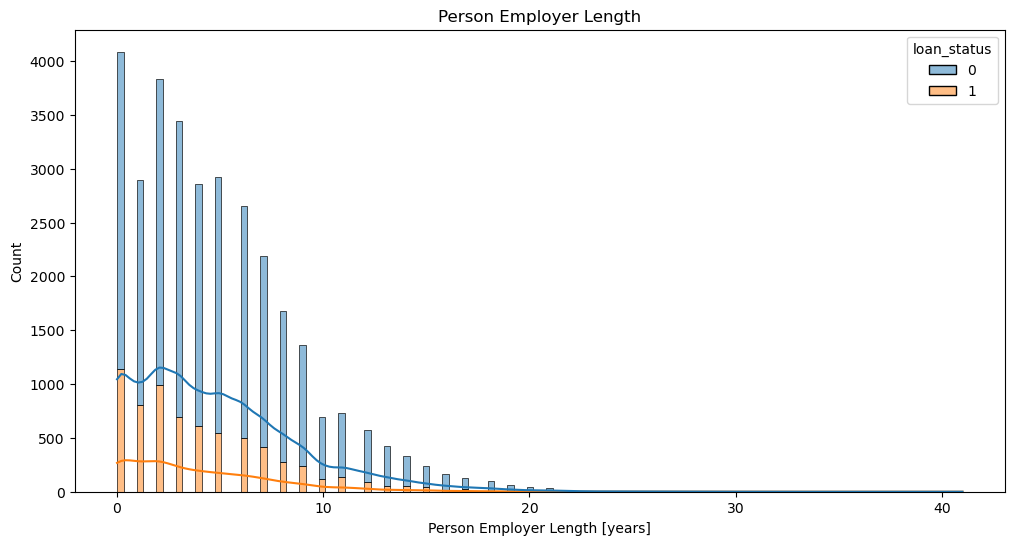

In [28]:
sns.set_palette('Paired')
plt.figure(figsize = (12,6))
sns.histplot(data=loan, x='person_emp_length', hue='loan_status', multiple='stack', kde=True)
plt.title('Person Employer Length')
plt.xlabel('Person Employer Length [years]')
plt.ylabel('Count')
plt.show()

### Preprocessing

Here below we define the features dataframe X and the target array y. Then we write the preprocessing pipelines for each different kind of feature:

- Ordinal Categorical: Ordinal encoder + MinMaxScaler
- Nominal Categorical: One Hot Encoder
- Numerical: Simpler imputer + Robust Scaler

Then we pass the three pipelines to the ColumnTransformer(). In the end we split the dataset into train and test and we apply the ColumnTransformer() to the split data. Since the dataset is moderately unbalanced as seen before, we use the stratify option in order to create train and test subset with the same target class ratio.

In [29]:
X = loan.drop('loan_status', axis=1).reset_index(drop=True) # Features
y = loan['loan_status'].reset_index(drop=True) # Target

In [30]:
#Pipeline definition
categorical_ordinal_pipeline = Pipeline(steps=[("oe", OrdinalEncoder()),("mmscale", MinMaxScaler())])
categorical_nominal_pipeline = Pipeline(steps=[("ohe", OneHotEncoder())])
numerical_pipeline = Pipeline(steps=[("impute", SimpleImputer(strategy="mean")),("scale", RobustScaler())])

In [31]:
ord_cols = ['loan_grade']
cat_cols = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'] # Select categorical columns
num_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 
            'loan_percent_income'] # Select numerical columns

ct = ColumnTransformer(transformers=[("numerical", numerical_pipeline, num_cols),
                                    ("categorical", categorical_nominal_pipeline, cat_cols),
                                    ("ordinal", categorical_ordinal_pipeline, ord_cols)])

ct

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scale', RobustScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income']),
                                ('categorical',
                                 Pipeline(steps=[('ohe', OneHotEncoder())]),
                                 ['person_home_ownership', 'loan_intent',
                                  'cb_person_default_on_file']),
                                ('ordinal',
                                 Pipeline(steps=[('oe', OrdinalEncoder()),
                                                 ('mmscale', MinMaxScaler())]),
                                 ['loan_grade'])])

In [32]:
# Apply train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)

In [33]:
X_train_processed = ct.fit_transform(X_train)
X_test_processed = ct.transform(X_test)

Note: the new transformed features are:

- from f0 to f5: numerical features scaled with the RobustScaler
- f6 to f17: categorical nominal features encoded with OneHotEncoder
- f18: categorical ordinal feature encoded with OrdinalEncoder and scaled with MinMaxScaler

In [34]:
df= pd.DataFrame(X_train_processed)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.857143,1.892265,-0.4,0.441379,-0.166002,-0.428571,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.166667
1,-0.428571,-0.622456,-0.8,-0.137931,0.356482,0.571429,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.166667
2,-0.428571,-0.497965,0.0,-0.689655,0.604876,-0.428571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.333333
3,0.571429,-0.024898,-0.4,-0.413793,0.878966,-0.428571,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.666667
4,-0.428571,0.224084,0.0,-0.337931,-0.799835,-0.428571,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000


### Model Evaluation and Selection

In this section we evaluate some baseline and some ensemble models without hyperparmeter tuning and we compare the evaluation metrics calculated on the test set. The models chosen are:

- Decision Tree
- Logistic Regression
- KNN Classifier
- Random Forest Classifier
- XGBoost Classifier
- CatBoost Classifier

For each model we print the classification report, a confusion matrix and test and train accuracies as an overfit check.

#### Decision Tree

In [35]:
#Decision Tree
dt = DecisionTreeClassifier(max_depth=8, random_state=42)
dt.fit(X_train_processed,y_train)
y_pred_dt = dt.predict(X_test_processed)
print(classification_report(y_test,y_pred_dt))
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
print('F1 score average is: %.3f' %(f1_dt))
recall_dt = recall_score(y_test, y_pred_dt, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_dt))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7597
           1       0.97      0.71      0.82      2126

    accuracy                           0.93      9723
   macro avg       0.95      0.85      0.89      9723
weighted avg       0.93      0.93      0.93      9723

F1 score average is: 0.929
Recall score (class 1) is: 0.714


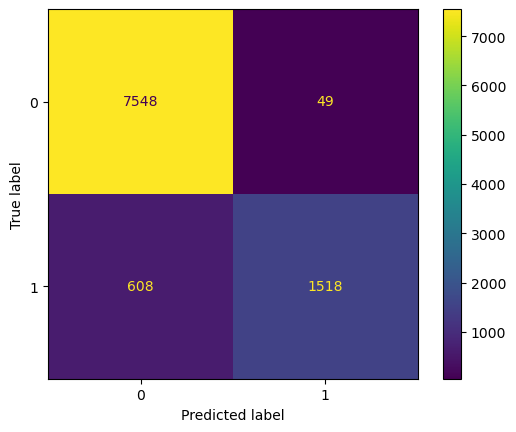

In [36]:
#Create and plot confusion matrix
confusion_matrix_dt = confusion_matrix(y_test, y_pred_dt)
cm_display_dt = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt, display_labels=['0','1'])
cm_display_dt.plot()
plt.show()

In [37]:
#Compute accuracy on the training set
train_accuracy_dt = dt.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_dt = dt.score(X_test_processed, y_test) 

train_accuracy_dt, test_accuracy_dt

(0.9345852067354316, 0.9324282628818266)

#### Logistic Regression

In [38]:
#Logistic Regression classifier
lr = LogisticRegression(random_state=42)
lr.fit(X_train_processed,y_train)
y_pred_lr = lr.predict(X_test_processed)
print(classification_report(y_test,y_pred_lr))
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
print('F1-score average is: %.3f' %(f1_lr))
recall_lr = recall_score(y_test, y_pred_lr, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_lr))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7597
           1       0.73      0.50      0.59      2126

    accuracy                           0.85      9723
   macro avg       0.80      0.72      0.75      9723
weighted avg       0.84      0.85      0.84      9723

F1-score average is: 0.839
Recall score (class 1) is: 0.498


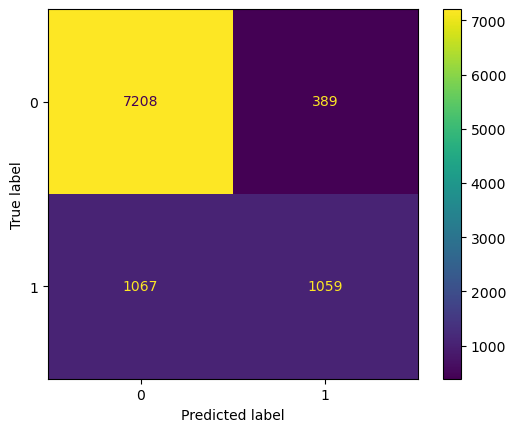

In [39]:
#Create and plot confusion matrix
confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_lr, display_labels=['0','1'])
cm_display_lr.plot()
plt.show()

In [40]:
#Compute accuracy on the training set
train_accuracy_lr = lr.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_lr = lr.score(X_test_processed, y_test) 

train_accuracy_lr, test_accuracy_lr

(0.8539187163889623, 0.8502519798416127)

#### KNN Classifier

In [41]:
#KNN classifier
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_processed,y_train)
y_pred_knn = knn.predict(X_test_processed)
print(classification_report(y_test,y_pred_knn))
f1_knn =f1_score(y_test, y_pred_knn, average='weighted')
print('F1-score average is: %.3f' %(f1_knn))
recall_knn = recall_score(y_test, y_pred_knn, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_knn))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      7597
           1       0.88      0.49      0.63      2126

    accuracy                           0.87      9723
   macro avg       0.88      0.73      0.77      9723
weighted avg       0.87      0.87      0.86      9723

F1-score average is: 0.859
Recall score (class 1) is: 0.485


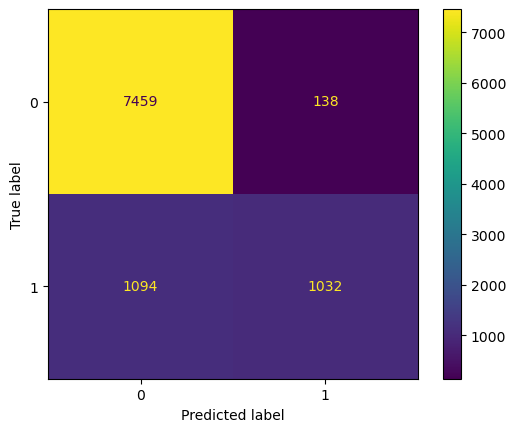

In [42]:
#Create and plot confusion matrix
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
cm_display_knn = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_knn, display_labels=['0','1'])
cm_display_knn.plot()
plt.show()

In [43]:
#Compute accuracy on the training set
train_accuracy_knn = knn.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_knn = knn.score(X_test_processed, y_test) 

train_accuracy_knn, test_accuracy_knn

(0.8897998765758618, 0.8732901367890569)

#### Random Forest Classifier

In [44]:
# Random Forest Classifier
rf = RandomForestClassifier(max_depth=8, class_weight='balanced_subsample', random_state=42)
rf.fit(X_train_processed,y_train)
y_pred_rf = rf.predict(X_test_processed)
print(classification_report(y_test,y_pred_rf))
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print('F1-score average is: %.3f' %(f1_rf))
recall_rf = recall_score(y_test, y_pred_rf, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_rf))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7597
           1       0.79      0.76      0.77      2126

    accuracy                           0.90      9723
   macro avg       0.86      0.85      0.86      9723
weighted avg       0.90      0.90      0.90      9723

F1-score average is: 0.902
Recall score (class 1) is: 0.760


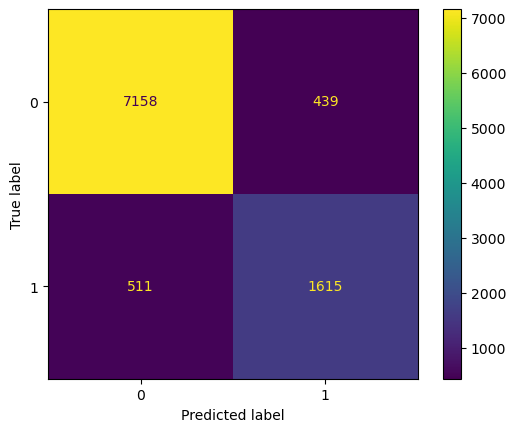

In [45]:
#Create and plot confusion matrix
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf, display_labels=['0','1'])
cm_display_rf.plot()
plt.show()

In [46]:
#Compute accuracy on the training set
train_accuracy_rf = rf.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_rf = rf.score(X_test_processed, y_test) 

train_accuracy_rf, test_accuracy_rf

(0.9121925416556467, 0.90229353080325)

#### XGBoost Classifier

In [47]:
#XGBoost Classifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_processed,y_train)
y_pred_xgb = xgb.predict(X_test_processed)
print(classification_report(y_test,y_pred_xgb))
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
print('F1-score average is: %.3f' %(f1_xgb))
recall_xgb = recall_score(y_test, y_pred_xgb, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_xgb))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7597
           1       0.95      0.75      0.84      2126

    accuracy                           0.94      9723
   macro avg       0.94      0.87      0.90      9723
weighted avg       0.94      0.94      0.93      9723

F1-score average is: 0.934
Recall score (class 1) is: 0.749


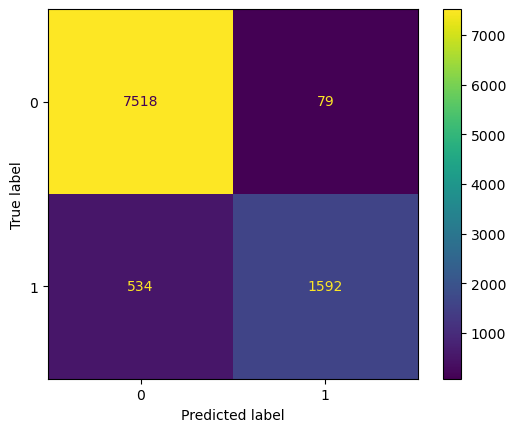

In [48]:
#Create and plot confusion matrix
confusion_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_display_xgb = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xgb, display_labels=['0','1'])
cm_display_xgb.plot()
plt.show()

In [49]:
#Compute accuracy on the training set
train_accuracy_xgb = xgb.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_xgb = xgb.score(X_test_processed, y_test) 

train_accuracy_xgb, test_accuracy_xgb

(0.9602838755179406, 0.9369536151393603)

#### CATBoost Classifier

In [50]:
#CATboost Classifier
catb = CatBoostClassifier(verbose=0, random_state=42)
catb.fit(X_train_processed,y_train)
y_pred_catb = catb.predict(X_test_processed)
print(classification_report(y_test,y_pred_catb))
f1_catb = f1_score(y_test, y_pred_catb, average='weighted')
print('F1-score average is: %.3f' %(f1_catb))
recall_catb = recall_score(y_test, y_pred_catb, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_catb))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7597
           1       0.97      0.74      0.84      2126

    accuracy                           0.94      9723
   macro avg       0.95      0.87      0.90      9723
weighted avg       0.94      0.94      0.94      9723

F1-score average is: 0.935
Recall score (class 1) is: 0.738


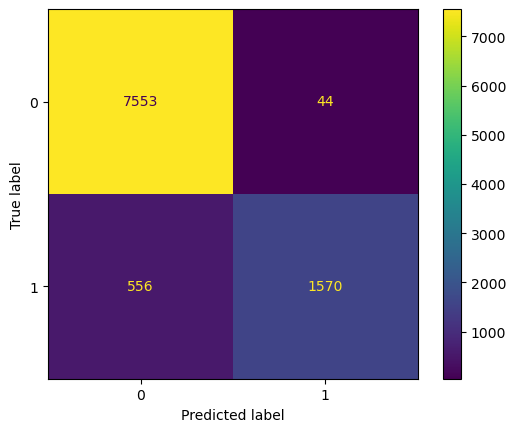

In [51]:
#Create and plot confusion matrix
confusion_matrix_catb = confusion_matrix(y_test, y_pred_catb)
cm_display_catb = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_catb, display_labels=['0','1'])
cm_display_catb.plot()
plt.show()

In [52]:
#Compute accuracy on the training set
train_accuracy_catb = catb.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_catb = catb.score(X_test_processed, y_test) 

train_accuracy_catb, test_accuracy_catb

(0.9494401833730054, 0.9382906510336316)

As can be seen in the barplots below, the best performing model so far is the CatBoost with F1 weighted average = 93.5%. XGBoost has also a high f1 weighted, around 93% however the best model so far, if we look only at the recall metrics only, is Random Forest with 76% recall on class 1, with XGBoost and CatBoost scoring 75% and 74% relatively.

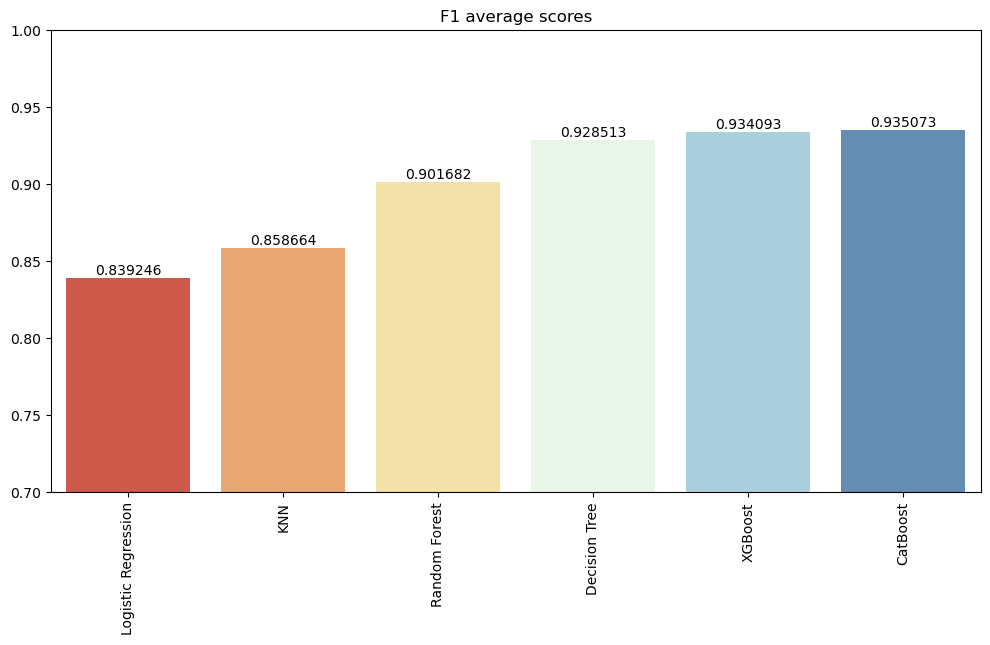

In [53]:
#Plot Model Average Scores before model optimization

sns.set_palette('RdYlBu')
plt.figure(figsize = (12,6))

classifier = ['Decision Tree','Logistic Regression','KNN', 'Random Forest', 'XGBoost', 'CatBoost']
f1 = [f1_dt, f1_lr, f1_knn, f1_rf, f1_xgb, f1_catb]

# Plot Bar chart
df = pd.DataFrame({"Classifier": classifier,
                  "F1_score": f1})
# Plot Bar chart
ax = sns.barplot(classifier,f1, order=df.sort_values('F1_score').Classifier)

plt.tick_params(axis='x', labelrotation=90)
plt.title('F1 average scores')
plt.ylim(0.7, 1.0)

ax.bar_label(ax.containers[0])

# Display graph
plt.show()

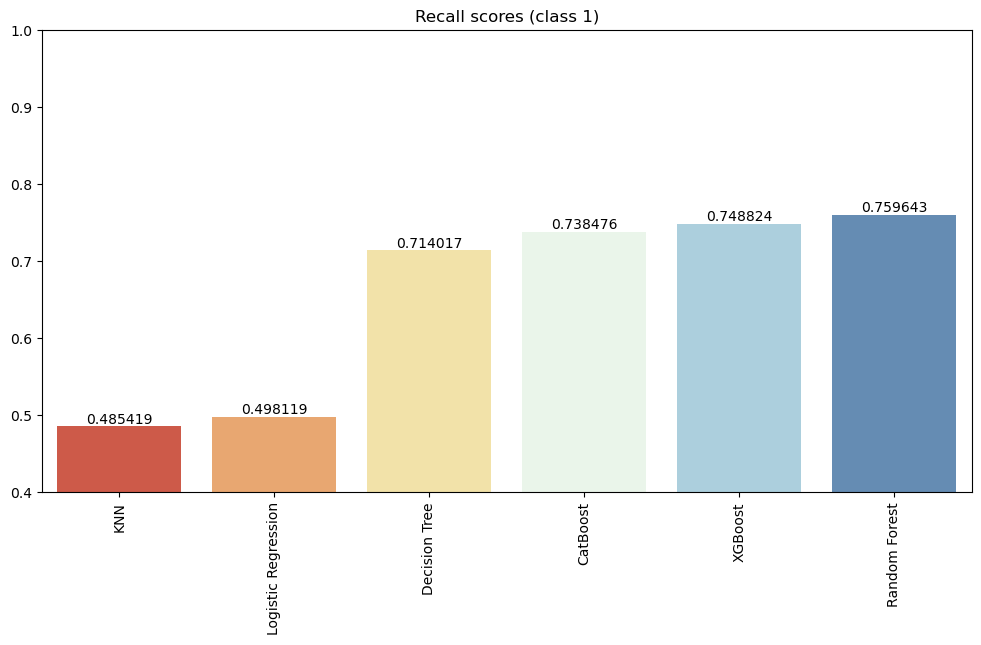

In [54]:
#Plot Model Recall Scores on Class 1 before model optimization

sns.set_palette('RdYlBu')
plt.figure(figsize = (12,6))

classifier = ['Decision Tree','Logistic Regression','KNN', 'Random Forest', 'XGBoost', 'CatBoost']
recall = [recall_dt, recall_lr, recall_knn, recall_rf, recall_xgb, recall_catb]

# Plot Bar chart
df = pd.DataFrame({"Classifier": classifier,
                  "Recall Score": recall})
# Plot Bar chart
ax = sns.barplot(classifier,recall, order=df.sort_values('Recall Score').Classifier)

plt.tick_params(axis='x', labelrotation=90)
plt.title('Recall scores (class 1)')
plt.ylim(0.4, 1.0)

ax.bar_label(ax.containers[0])

# Display graph
plt.show()

### Models Optimization

Here below we decide to perform a hyperparameter tuning with Randomized Search on the three best performing models trained so far i.e. Random Forest, XGBoost and CatBoost. At the end of the optimization we train also a voting classifier with both soft and hard options.

All three models are optmized based on the recall scoring since we are looking for a model that is able to predict default customers with a low number of false negatives. Indeed we care less about precision than recall since, in this particular problem, it is key to identify correctly the biggest number of customers with high default risk.

In [55]:
#Common Hyperparameters for Randomized Search
n_iter = 10
cv = 5

#### Random Forest Classifier - Hyperparameter Tuning with Randomized Search

In [56]:
#Define the search space
random_grid_rf = {'n_estimators': [400, 600, 800, 1000, 1500, 3000, 5000, 10000, 15000], # Number of trees
               'max_features': ['auto', 'sqrt'], # Number of features for every split
               'max_depth': [4, 5, 6, 7, 8, 9, 10, 15, 20], # Maximum number of levels in a tree
               'min_samples_split': [2, 5, 10, 15, 20, 25], # Minimum number of samples necessary to split a single node
               'min_samples_leaf': [2, 4 ,6, 8, 10], # Minimum number of samples necessary at each leaf node
               'bootstrap': [True, False], # Method of selecting samples for training each single tree. If False, the whole dataset is used to build each tree.
               'class_weight' : ['balanced', 'balanced_subsample']} #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies. 
                                                                    #The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

In [57]:
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                                param_distributions = random_grid_rf, 
                                n_iter = n_iter, 
                                scoring='recall', 
                                cv = cv, 
                                verbose=0, 
                                random_state=42, 
                                n_jobs = -1)
# Fit the random search model
random_search_rf.fit(X_train_processed, y_train)
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_search_rf.best_score_:.3f}')
print(f'The best hyperparameters are {random_search_rf.best_params_}')

In [ ]:
rf_opti=random_search_rf.best_estimator_
y_pred_rf_opti = rf_opti.predict(X_test_processed)
print(classification_report(y_test,y_pred_rf_opti))
f1_rf_opti = f1_score(y_test, y_pred_rf_opti, average='weighted')
print('F1-score average is: %.3f' %(f1_rf_opti))
recall_rf_opti = recall_score(y_test, y_pred_rf_opti, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_rf_opti))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7597
           1       0.74      0.77      0.75      2126

    accuracy                           0.89      9723
   macro avg       0.84      0.85      0.84      9723
weighted avg       0.89      0.89      0.89      9723

F1-score average is: 0.891
Recall score (class 1) is: 0.772


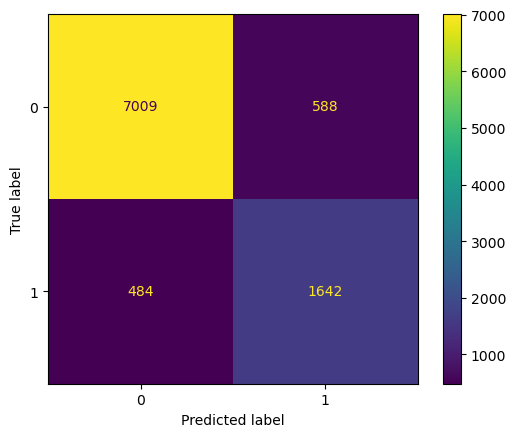

In [ ]:
#Create and plot confusion matrix
confusion_matrix_rf_opti = confusion_matrix(y_test, y_pred_rf_opti)
cm_display_rf_opti = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf_opti, display_labels=['0','1'])
cm_display_rf_opti.plot()
plt.show()

In [ ]:
#Compute accuracy on the training set
train_accuracy_rf_opti = rf_opti.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_rf_opti = rf_opti.score(X_test_processed, y_test) 

train_accuracy_rf_opti, test_accuracy_rf_opti

(0.8905492374151459, 0.8897459631800885)

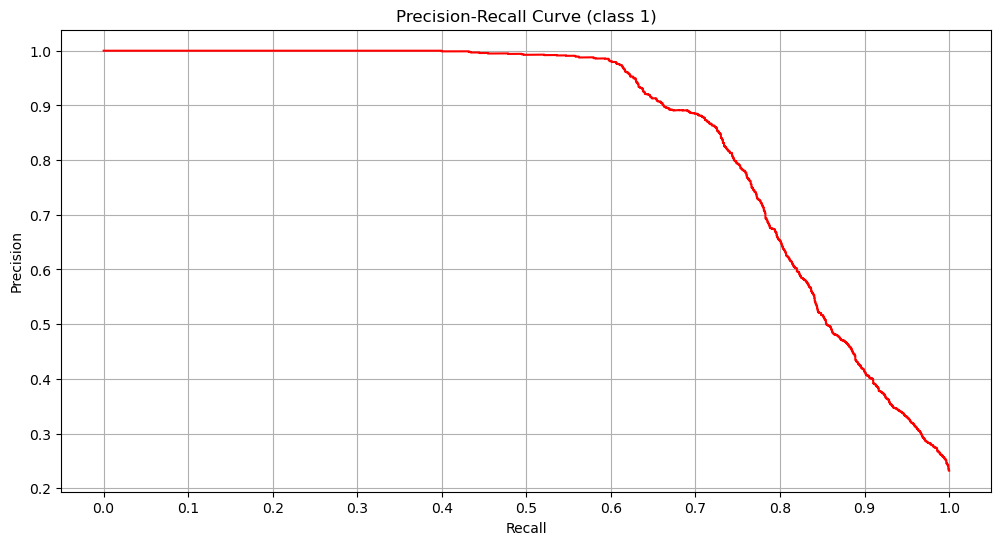

In [ ]:
y_score_rf_opti = rf_opti.predict_proba(X_test_processed)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score_rf_opti)

sns.set_palette('tab10')
plt.figure(figsize = (12,6))

#create precision recall curve
plt.plot(recall, precision, color='red')

#add axis labels to plot
plt.title('Precision-Recall Curve (Random Forest Classifier Tuned)')
plt.ylabel('Precision')
plt.xlabel('Recall')


# Create an array of x-ticks from 0 to 1 with a step of 0.1
x_ticks = np.arange(0, 1.1, 0.1)

# Set the x-ticks and enable the grid lines
plt.xticks(x_ticks)
plt.grid()

#add axis labels to plot
plt.title('Precision-Recall Curve (class 1)')
plt.ylabel('Precision')
plt.xlabel('Recall')

#display plot
plt.show()


#### XGBoost Classifier - Hyperparameter Tuning with Randomized Search

In [ ]:
# Define the search space
random_grid_xgb = { 
    "learning_rate": [0.005, 0.01, 0.02, 0.03, 0.05],
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "gamma": [0, 0.001, 0.01, 0.1, 0.2, 0.3, 1, 5], #Minimum loss reduction to make a split
    "min_child_weight" : [1, 2, 3, 4],  #Minimum sum of weights of all observations required in a child
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], #subsample ratio of columns when constructing each tree
    "reg_alpha": [0, 1e-2, 0.1, 1], #L1 regularization term on weights
    "reg_lambda": [0, 1e-2, 0.1, 1],  #L2 regularization term on weights
    "scale_pos_weight": [1,2,3,4,5] #It deals with imbalanced datasets. It's calculated as the ratio between bigger class vs smaller class
     }

In [ ]:
# Define random search
random_search_xgb = RandomizedSearchCV(estimator=XGBClassifier(), 
                           param_distributions=random_grid_xgb, 
                           n_iter = 50,
                           scoring = 'recall',  
                           n_jobs = -1, 
                           cv = cv, 
                           verbose = 0, 
                           random_state = 42)
# Fit grid search
random_search_xgb.fit(X_train_processed, y_train)
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_search_xgb.best_score_:.3f}')
print(f'The best hyperparameters are {random_search_xgb.best_params_}')

The best score is 0.817
The best hyperparameters are {'scale_pos_weight': 5, 'reg_lambda': 0.1, 'reg_alpha': 0, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.5}


In [ ]:
xgb_opti=random_search_xgb.best_estimator_
y_pred_xgb_opti = xgb_opti.predict(X_test_processed)
print(classification_report(y_test,y_pred_xgb_opti))
f1_xgb_opti = f1_score(y_test, y_pred_xgb_opti, average='weighted')
print('F1-score average is: %.3f' %(f1_xgb_opti))
recall_xgb_opti = recall_score(y_test, y_pred_xgb_opti, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_xgb_opti))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      7597
           1       0.67      0.82      0.74      2126

    accuracy                           0.87      9723
   macro avg       0.81      0.86      0.83      9723
weighted avg       0.89      0.87      0.88      9723

F1-score average is: 0.877
Recall score (class 1) is: 0.825


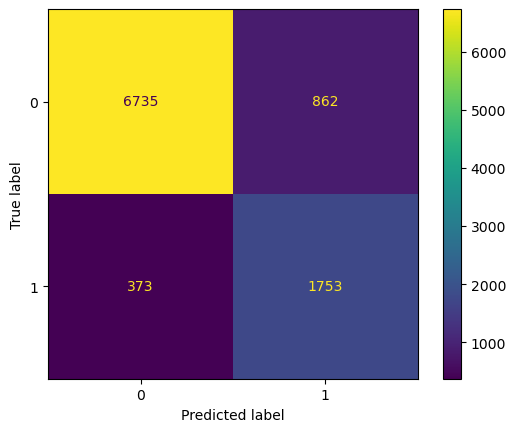

In [ ]:
#Create and plot confusion matrix
confusion_matrix_xgb_opti = confusion_matrix(y_test, y_pred_xgb_opti)
cm_display_xgb_opti = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xgb_opti, display_labels=['0','1'])
cm_display_xgb_opti.plot()
plt.show()

In [ ]:
#Compute accuracy on the training set
train_accuracy_xgb_opti = xgb_opti.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_xgb_opti = xgb_opti.score(X_test_processed, y_test) 

train_accuracy_xgb_opti, test_accuracy_xgb_opti

(0.8771048223574011, 0.872981590044225)

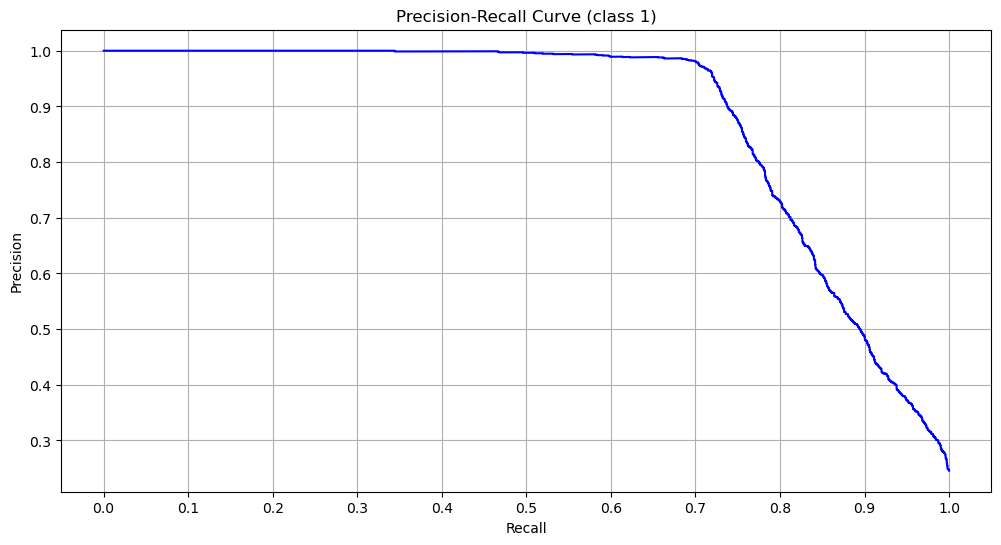

In [ ]:
y_score_xgb_opti = xgb_opti.predict_proba(X_test_processed)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score_xgb_opti)

sns.set_palette('tab10')
plt.figure(figsize = (12,6))

#create precision recall curve
plt.plot(recall, precision, color='blue')

#add axis labels to plot
plt.title('Precision-Recall Curve (XGBoost Classifier Tuned)')
plt.ylabel('Precision')
plt.xlabel('Recall')

# Create an array of x-ticks from 0 to 1 with a step of 0.1
x_ticks = np.arange(0, 1.1, 0.1)

# Set the x-ticks and enable the grid lines
plt.xticks(x_ticks)
plt.grid()

#add axis labels to plot
plt.title('Precision-Recall Curve (class 1)')
plt.ylabel('Precision')
plt.xlabel('Recall')

#display plot
plt.show()

#### CATBoost Classifier - Hyperparameter Tuning with Randomized Search

In [ ]:
# Create the random grid
random_grid_catb = {'iterations' : [100, 200, 500], #Maximum number of trees that can be built.
               'learning_rate': [0.001, 0.005, 0.01], #The rate at which the model weights are updated after working through each batch of training examples.
               'depth':[2, 3, 4, 5, 6, 7, 8, 9, 10], #Depth of tree
               'subsample' : [0.1, 0.5, 0.8], #Fraction of the entire dataset to produce each tree
               'colsample_bylevel' : [0.05, 0.1, 0.5], #Fraction of features to be chosen at each node for each split during tree building process
               'l2_leaf_reg': [1,2,3,4,5], #Coefficient for the L2 regularization term of the cost function.
               'min_data_in_leaf' : [1,5,10,50,100,150], #Minimum number of samples required to create a leaf
               'scale_pos_weight': [1,2,3,4]} #It deals with imbalanced datasets. It's calculated as the ratio between bigger class vs smaller class

In [ ]:
random_search_catb = RandomizedSearchCV(estimator = CatBoostClassifier(verbose=False), 
                                param_distributions = random_grid_catb, 
                                n_iter = n_iter, 
                                scoring='recall', 
                                cv = cv, 
                                verbose=False, 
                                random_state=42, 
                                n_jobs = -1);
# Fit the random search model
random_search_catb.fit(X_train_processed, y_train);
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_search_catb.best_score_:.3f}');
print(f'The best hyperparameters are {random_search_catb.best_params_}');

The best score is 0.795
The best hyperparameters are {'subsample': 0.5, 'scale_pos_weight': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.001, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 9, 'colsample_bylevel': 0.1}


In [ ]:
catb_opti=random_search_catb.best_estimator_
y_pred_catb_opti = catb_opti.predict(X_test_processed)
print(classification_report(y_test,y_pred_catb_opti));
f1_catb_opti = f1_score(y_test, y_pred_catb_opti, average='weighted')
print('F1-score average is: %.3f' %(f1_catb_opti));
recall_catb_opti = recall_score(y_test, y_pred_catb_opti, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_catb_opti));

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      7597
           1       0.59      0.79      0.68      2126

    accuracy                           0.84      9723
   macro avg       0.77      0.82      0.79      9723
weighted avg       0.86      0.84      0.84      9723

F1-score average is: 0.844
Recall score (class 1) is: 0.794


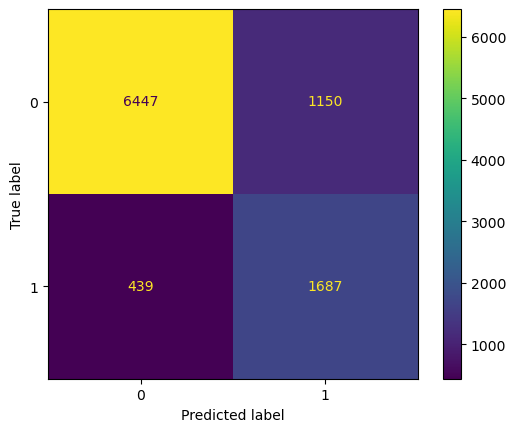

In [ ]:
#Create and plot confusion matrix
confusion_matrix_catb_opti = confusion_matrix(y_test, y_pred_catb_opti)
cm_display_catb_opti = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_catb_opti, display_labels=['0','1'])
cm_display_catb_opti.plot()
plt.show()

In [ ]:
#Compute accuracy on the training set
train_accuracy_catb_opti = catb_opti.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_catb_opti = catb_opti.score(X_test_processed, y_test) 

train_accuracy_catb_opti, test_accuracy_catb_opti

(0.8409591818742836, 0.8365730741540677)

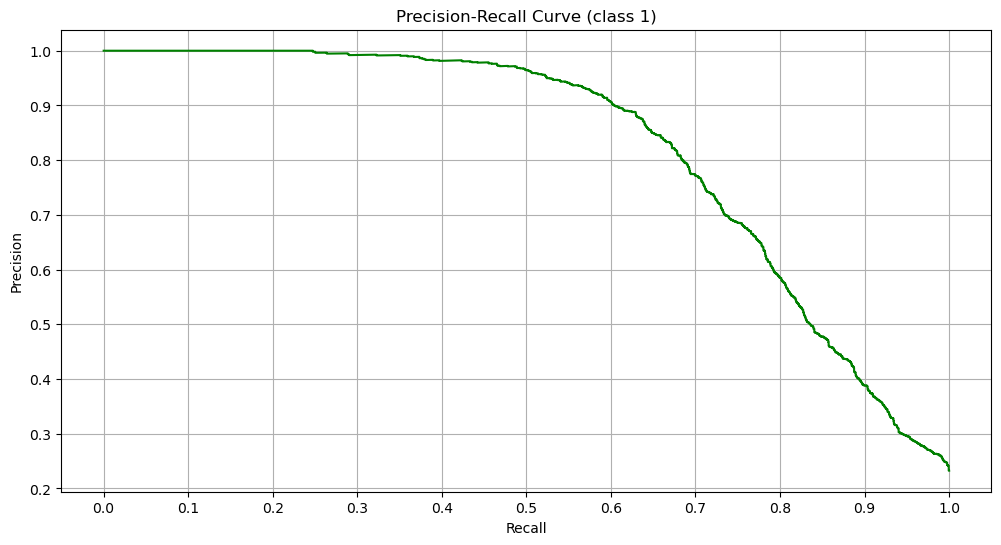

In [ ]:
y_score_catb_opti = catb_opti.predict_proba(X_test_processed)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score_catb_opti)

sns.set_palette('tab10')
plt.figure(figsize = (12,6))

#create precision recall curve
plt.plot(recall, precision, color='green')

# Create an array of x-ticks from 0 to 1 with a step of 0.1
x_ticks = np.arange(0, 1.1, 0.1)

# Set the x-ticks and enable the grid lines
plt.xticks(x_ticks)
plt.grid()

#add axis labels to plot
plt.title('Precision-Recall Curve (class 1)')
plt.ylabel('Precision')
plt.xlabel('Recall')

#display plot
plt.show()

Here below we compare the precision recall curves of the three tuned ensemble models. We can see that XGBoost is a clear winner with a higher Area Under the Curve.

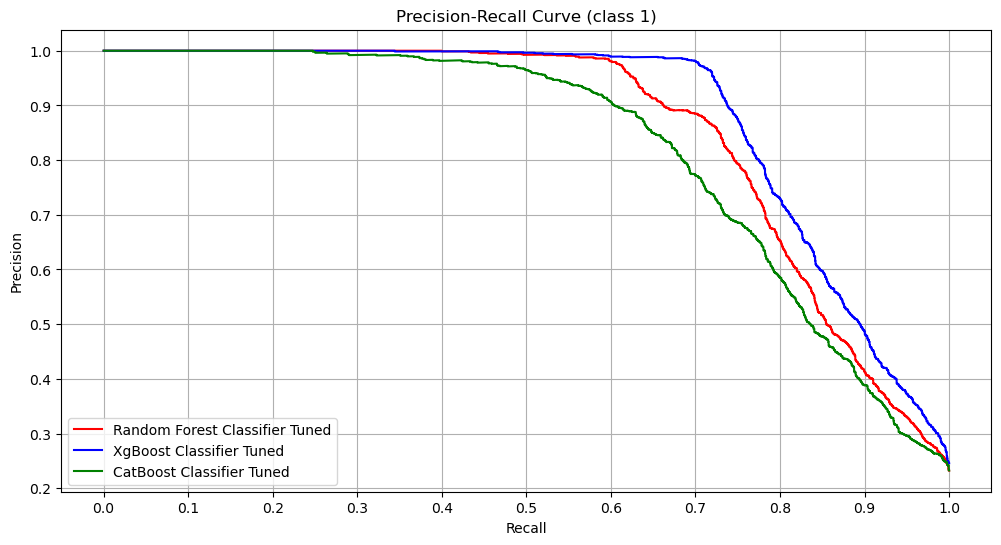

In [ ]:
sns.set_palette('tab10')
plt.figure(figsize = (12,6))

#calculate precision and recall for Random Forest Classifier
precision_rf_o, recall_rf_o, thresholds_rf_o = precision_recall_curve(y_test, y_score_rf_opti)
plt.plot(recall_rf_o, precision_rf_o, color='red', label='Random Forest Classifier Tuned')

#calculate precision and recall for XGBoost Classifier
precision_xgb_o, recall_xgb_o, thresholds_xgb_o = precision_recall_curve(y_test, y_score_xgb_opti)
plt.plot(recall_xgb_o, precision_xgb_o, color='blue', label='XgBoost Classifier Tuned')

#calculate precision and recall for CatBoost Classifier
precision_catb_o, recall_catb_o, thresholds_catb_o = precision_recall_curve(y_test, y_score_catb_opti)
plt.plot(recall_catb_o, precision_catb_o, color='green', label='CatBoost Classifier Tuned')

#add axis labels to plot
plt.title('Precision-Recall Curve (class 1)')
plt.ylabel('Precision')
plt.xlabel('Recall')

# Create an array of x-ticks from 0 to 1 with a step of 0.1
x_ticks = np.arange(0, 1.1, 0.1)

# Set the x-ticks and enable the grid lines
plt.xticks(x_ticks)
plt.grid()

plt.legend()

#display plot
plt.show()

#### Voting Classifier - Hard Voting

In [ ]:
#Voting Classifier - hard voting
vc_hard = VotingClassifier(estimators=[('Random Forest Classifier Tuned', rf_opti), 
                                ('XGBoost Classifier Tuned', xgb_opti), 
                                ('CatBoost Classifier Tuned', catb_opti)], 
                                voting='hard');
vc_hard.fit(X_train_processed,y_train);
y_pred_vc_hard = vc_hard.predict(X_test_processed)
print(classification_report(y_test,y_pred_vc_hard));
f1_vc_hard = f1_score(y_test, y_pred_vc_hard, average='weighted')
print('F1-score average is: %.3f' %(f1_vc_hard));
recall_vc_hard = recall_score(y_test, y_pred_vc_hard, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_vc_hard));

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      7597
           1       0.68      0.80      0.73      2126

    accuracy                           0.87      9723
   macro avg       0.81      0.84      0.82      9723
weighted avg       0.88      0.87      0.88      9723

F1-score average is: 0.876
Recall score (class 1) is: 0.795


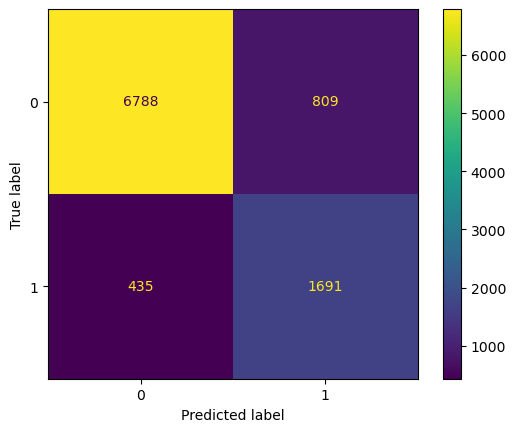

In [ ]:
#Create and plot confusion matrix
confusion_matrix_vc_hard = confusion_matrix(y_test, y_pred_vc_hard)
cm_display_vc_hard = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_vc_hard, display_labels=['0','1'])
cm_display_vc_hard.plot()
plt.show()

In [ ]:
#Compute accuracy on the training set
train_accuracy_vc_hard = vc_hard.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_vc_hard = vc_hard.score(X_test_processed, y_test) 

train_accuracy_vc_hard, test_accuracy_vc_hard

(0.8751653001851362, 0.8720559498097296)

#### Voting Classifier - Soft Voting

In [ ]:
#Voting Classifier - hard voting
vc_soft = VotingClassifier(estimators=[('Random Forest Classifier Tuned', rf_opti), 
                                ('XGBoost Classifier Tuned', xgb_opti), 
                                ('CatBoost Classifier Tuned', catb_opti)], 
                                voting='soft');
                                
vc_soft.fit(X_train_processed,y_train);
y_pred_vc_soft = vc_soft.predict(X_test_processed)
print(classification_report(y_test,y_pred_vc_soft));
f1_vc_soft = f1_score(y_test, y_pred_vc_soft, average='weighted')
print('F1-score average is: %.3f' %(f1_vc_soft));
recall_vc_soft = recall_score(y_test, y_pred_vc_soft, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_vc_soft));

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      7597
           1       0.70      0.79      0.75      2126

    accuracy                           0.88      9723
   macro avg       0.82      0.85      0.83      9723
weighted avg       0.89      0.88      0.88      9723

F1-score average is: 0.884
Recall score (class 1) is: 0.794


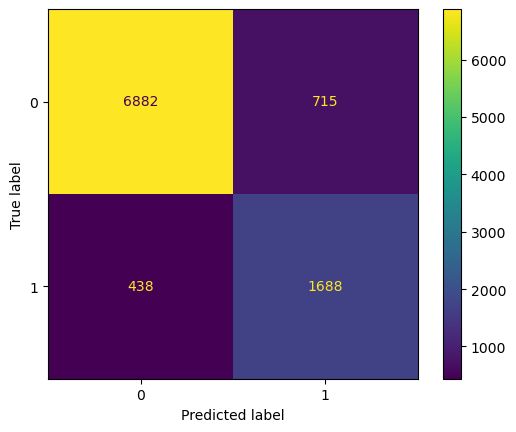

In [ ]:
#Create and plot confusion matrix
confusion_matrix_vc_soft = confusion_matrix(y_test, y_pred_vc_soft)
cm_display_vc_soft = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_vc_soft, display_labels=['0','1'])
cm_display_vc_soft.plot()
plt.show()

In [ ]:
#Compute accuracy on the training set
train_accuracy_vc_soft = vc_soft.score(X_train_processed, y_train)
#Compute accuracy on the test set
test_accuracy_vc_soft = vc_soft.score(X_test_processed, y_test) 

train_accuracy_vc_soft, test_accuracy_vc_soft

(0.8855241117870052, 0.8814152010696287)

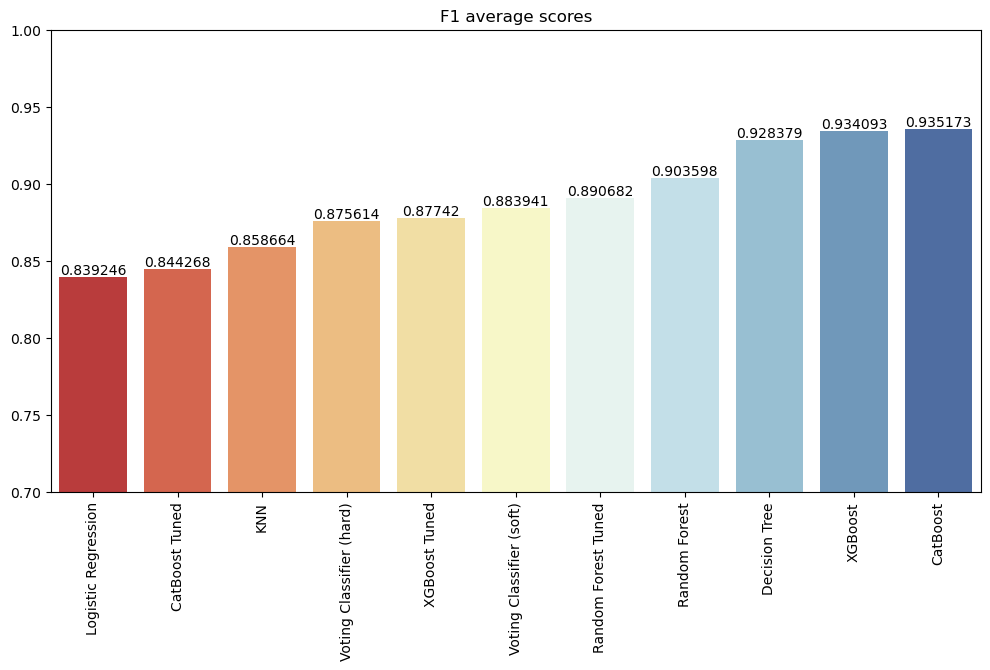

In [ ]:
#Plot Model Average Scores after model optimization

plt.figure(figsize = (12,6))

classifier = ['Decision Tree','Logistic Regression','KNN', 'Random Forest', 'XGBoost', 'CatBoost', 
            'Random Forest Tuned', 'XGBoost Tuned', 'CatBoost Tuned', 'Voting Classifier (hard)', 'Voting Classifier (soft)']
f1 = [f1_dt, f1_lr, f1_knn, f1_rf, f1_xgb, f1_catb, f1_rf_opti, f1_xgb_opti, f1_catb_opti, f1_vc_hard, f1_vc_soft]

# Plot Bar chart
df = pd.DataFrame({"Classifier": classifier,
                  "F1_score": f1})
# Plot Bar chart
ax = sns.barplot(classifier,f1, order=df.sort_values('F1_score').Classifier, palette='RdYlBu')

plt.tick_params(axis='x', labelrotation=90)
plt.title('F1 average scores')
plt.ylim(0.7, 1.0)

ax.bar_label(ax.containers[0])

# Display graph
plt.show()

Optimized XGBoost model is the clear winner scoring the best recall score on class 1 (82%) and a high f1 number (88%)

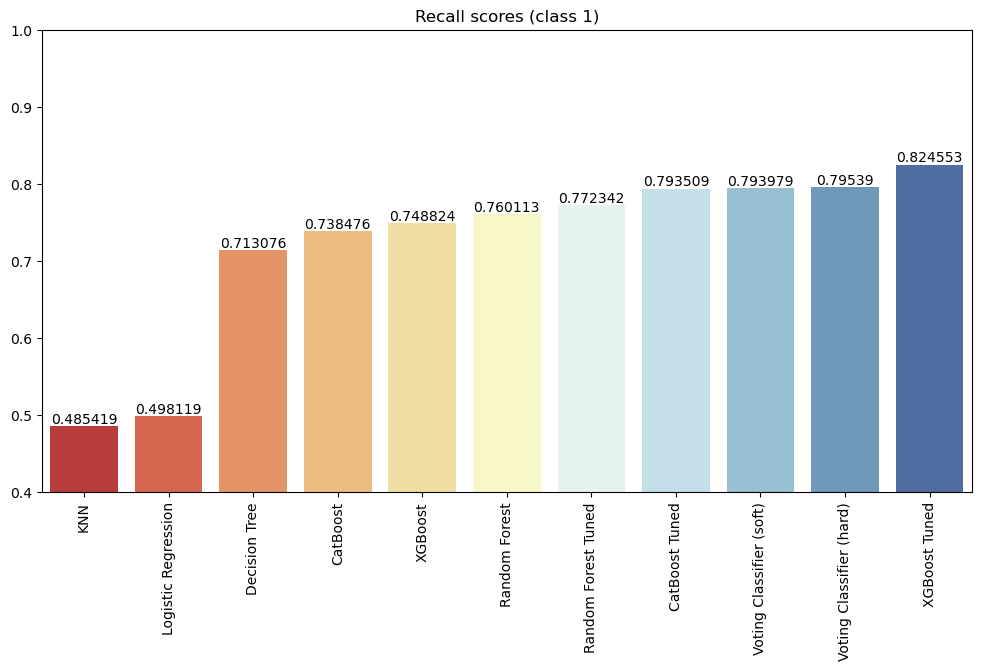

In [ ]:
#Plot Model Recall Scores on Class 1 after model optimization

plt.figure(figsize = (12,6))

classifier = ['Decision Tree','Logistic Regression','KNN', 'Random Forest', 'XGBoost', 'CatBoost', 
            'Random Forest Tuned', 'XGBoost Tuned', 'CatBoost Tuned', 'Voting Classifier (hard)', 'Voting Classifier (soft)']
recall = [recall_dt, recall_lr, recall_knn, recall_rf, recall_xgb, recall_catb, recall_rf_opti, recall_xgb_opti, recall_catb_opti, recall_vc_hard, recall_vc_soft]

# Plot Bar chart
df = pd.DataFrame({"Classifier": classifier,
                  "Recall Score": recall})
# Plot Bar chart
ax = sns.barplot(classifier,recall, order=df.sort_values('Recall Score').Classifier, palette='RdYlBu')

plt.tick_params(axis='x', labelrotation=90)
plt.title('Recall scores (class 1)')
plt.ylim(0.4, 1.0)

ax.bar_label(ax.containers[0])

# Display graph
plt.show()

### Feature Importance

The three highest importance features for XGBoost are 'person_home_ownership', 'loan_intent' and 'loan_percent_income'. From this analysis it is interesting to note also the two least important features being 'person_age' and 'person_emp_length' that could be dropped from the dataset given the low impact on the final model.

In [ ]:
xgb_opti.feature_importances_

array([0.0110526 , 0.07204209, 0.01757474, 0.02720433, 0.04052   ,
       0.17780164, 0.06015829, 0.01042001, 0.05583372, 0.0952376 ,
       0.03939321, 0.01621629, 0.03389735, 0.03534039, 0.01656014,
       0.03706975, 0.06815246, 0.02720819, 0.1583173 ], dtype=float32)

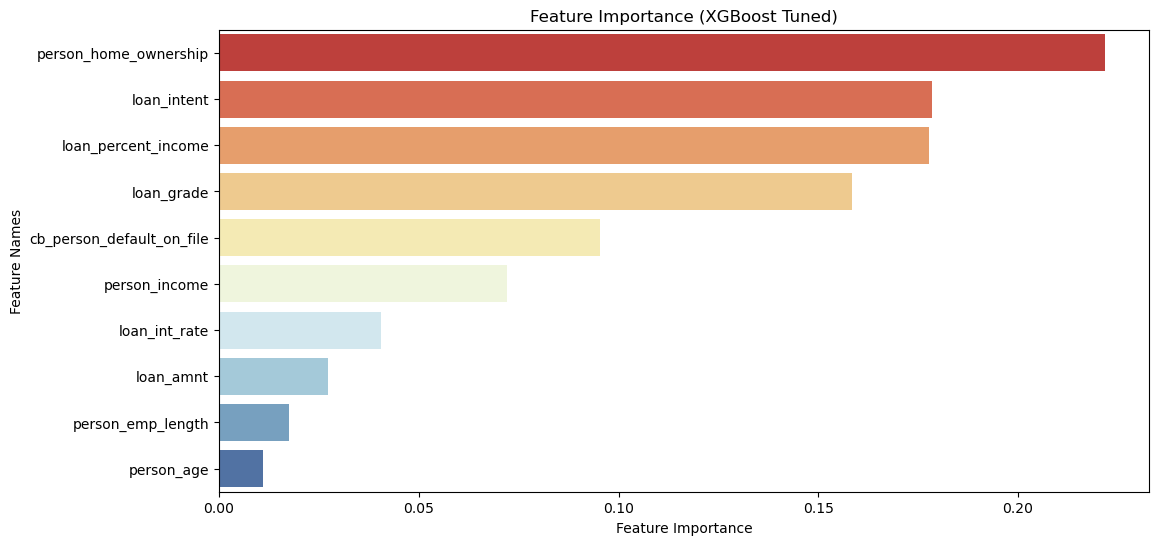

In [ ]:
plt.figure(figsize = (12,6))

slice0=xgb_opti.feature_importances_[0:6]

slice1=xgb_opti.feature_importances_[6:10]
agg1 = slice1.sum()

slice2=xgb_opti.feature_importances_[10:16]
agg2 = slice2.sum()

slice3=xgb_opti.feature_importances_[16:18]
agg3 = slice3.sum()

slice4=xgb_opti.feature_importances_[18:19]

features_aggregated = np.concatenate([slice0, [agg1], [agg2], [agg3], slice4])

xgb_opti_fi = {'Feature Names': num_cols + cat_cols + ord_cols,
        'Feature Importance': features_aggregated }

feature_importances_aggregated = pd.DataFrame(xgb_opti_fi).sort_values('Feature Importance', ascending=False)

sns.barplot(data=feature_importances_aggregated, y='Feature Names', x='Feature Importance', orient='h', palette='RdYlBu')
plt.title('Feature Importance (XGBoost Tuned)')

plt.show()

### Final Pipeline

Final pipeline is saved as final_project.joblib

In [ ]:
#Pipeline definition

pipe = Pipeline((('preprocessing',ct),('classifier',catb_opti)))

#Save Pipeline

import joblib
joblib.dump(pipe, 'final_project_pipeline.joblib')

['final_project_pipeline.joblib']

In [ ]:
#Load Pipeline

pipe = joblib.load('final_project_pipeline.joblib')

pipe

Pipeline(steps=(('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income']),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['person_home_ownership',
                                                   'loan_intent',
                                                   'cb_person_default_on_file']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('oe',
                                                                   OrdinalEncoder()),
                                                                  ('mmscale',
                                                                   MinMaxScaler())]),
                                                  ['loan_grade'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000019F6613A0D0>)))

### Conclusions

We have trained 11 different ML models on the credit_risk_dataset and compared the f1 number and recall metrics calculated on the test set for each of them. The best model if we look at recall is certainly the optimized XGBoost with a weighted average f1 score of 88%, a high recall of 82.5% on class 1 and the best precision recall curve.

Voting classifier (soft) is still a very good option if we are looking to achieve a more balanced model with slightly higher f1 and slightly lower recall.

Here below a few suggestions and recommendations for future work:

- Deploy other strategies to cope with unbalanced datasets and compare the results (downsampling, upsampling, syntentic data augmentation e.g. SMOTE, use of imbalanced learn library etc)
- Try more hyperparameters and higher ranges in order to improve the tuning results
- Try Bayesian Optimisation as a more efficient way to improve hyperparameter tuning
- Train more Ensemble methods based on DT (e.g. LightGBM)
- Drop least important features from the dataset and retrain the model
- Assign weights to each loan in order to optimize models that minimise financial loss